# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [1]:
import numpy as np 

#H = np.load('Hamiltonian_Example.npy')
# I have -2.0 < u 2.0 in steps of 0.1
u=4.0
t=-1
H = np.load('H_mu_'+str(u)+"_t_"+str(t)+'.npy')

In [2]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-2.10274848e+00, -1.80642385e+00, -1.06814039e+00, -8.28427125e-01,
       -8.28427125e-01,  8.70432672e-16,  5.81449281e-01,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.38787313e+00,
        2.96539191e+00,  3.17157288e+00,  3.17157288e+00,  4.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  4.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  4.82842712e+00,  4.82842712e+00,  5.03460809e+00,
        5.61212687e+00,  6.00000000e+00,  6.00000000e+00,  6.00000000e+00,
        6.00000000e+00,  7.41855072e+00,  8.00000000e+00,  8.82842712e+00,
        8.82842712e+00,  9.06814039e+00,  9.80642385e+00,  1.01027485e+01])

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [3]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [4]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [5]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,8.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,4.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [6]:
print(blocks['0,0'])

SummedOp([
  5.5 * III,
  -0.5 * IIX,
  IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -1.5 * IZI,
  -0.5 * IZX,
  IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -0.5 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [7]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-7-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-7-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [8]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,8,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,4,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,4,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,4,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,4,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,4,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,4,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,8,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [9]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

(-2.1027484834620758+0j)
-2.1027484834620758


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [10]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [23]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i


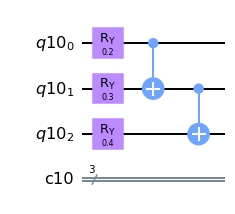

In [24]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [25]:
def U(cir,phi_b):
    for i in range(Q):
        cir.h(i)
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


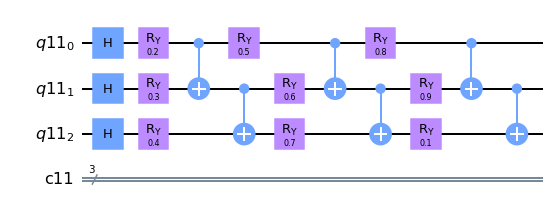

In [26]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to create this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [27]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

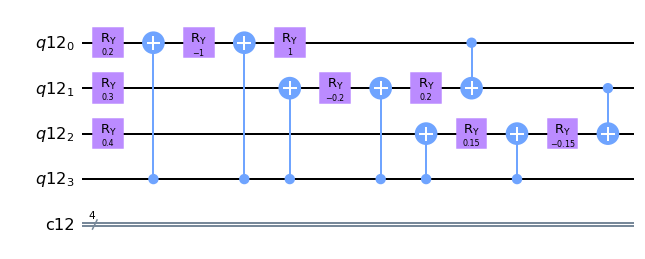

In [28]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

Let's check to make sure we are generating the right thing

In [29]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [30]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for i in range(Q):
        cir.h(i)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

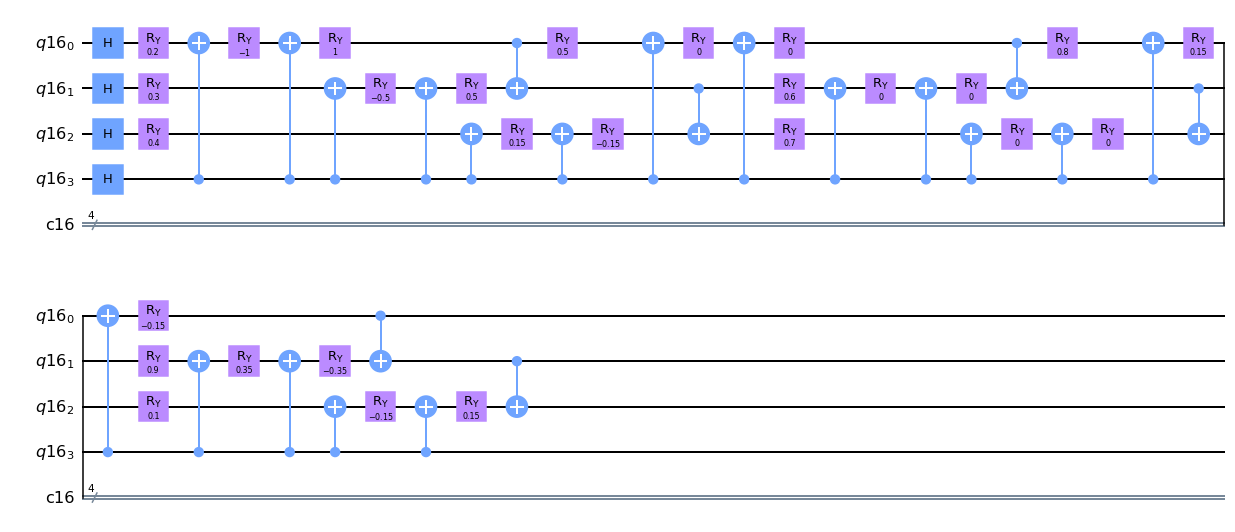

In [31]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [32]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][17].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.17026090873189856+0j)
0.17026090873189853
0.14453125


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [33]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from on diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = block.to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (2.258656750903852+0j)
simple: (2.258656750903852+0j)
matrix: 2.2586567509038513
simulator: 2.06787109375


In [34]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli('X' + p_label,psi,method = method)
        E += w*E_p
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = block.to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (-0.8924436187837783+0j)
simple: (-0.8924436187837781+0j)
matrix: -0.8924436187837779
simulator: -0.8955078125


Now we need to add all of the blocks together

In [35]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = 'simple')
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = 'simple')
    return E
            
find_E(alpha,phi,blocks)

(2.904984712318649+0j)

In [36]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(2.9049847123186483+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [37]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(3.499999999999999+0j)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [38]:
import copy

In [39]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    np.random.seed(10)
    
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [40]:
out = SPSA(3000,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= 0.2827906755928966 E_A= (4.092660685857669+0j) E_B= (3.8664281453833516+0j) E_f= 3.491886932319597
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= -0.821397758781745 E_A= (5.033789758746933+0j) E_B= (5.6464778949690135+0j) E_f= 3.462114256456997
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= 1.043615663726572 E_A= (5.1269214597742945+0j) E_B= (4.379713776213062+0j) E_f= 3.4834046929654177
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= 0.8873853674436962 E_A= (5.218514841342024+0j) E_B= (4.6013599278294945+0j) E_f= 3.4108877945212837
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= 3.6177134920891314 E_A= (5.630130354587314+0j) E_B= (3.1701695572279647+0j) E_f= 3.093533285412798
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= 2.3704419289432743 E_A= (5.45135227551572+0j) E_B= (3.868916724791291+0j) E_f= 2.908562957230926
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095918097278 g= -1.386660258325

k= 52 c_k= 0.267860162826851 a_k= 0.021742153317333094 g= -0.24492078878135143 E_A= (1.8734909495474081+0j) E_B= (2.0046999942727153+0j) E_f= 0.2537199100824696
k= 53 c_k= 0.26735494522142605 a_k= 0.021673439087867164 g= -0.9092200888365214 E_A= (1.6561576353257097+0j) E_B= (2.1423266094159263+0j) E_f= 0.27891565173445737
k= 54 c_k= 0.2668599250350944 a_k= 0.02160600238280336 g= -2.4179741737673255 E_A= (0.8512046148592829+0j) E_B= (2.1417254283559686+0j) E_f= 0.1807173281838694
k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= -1.1174357061114826 E_A= (1.222278285081122+0j) E_B= (1.8175915240537133+0j) E_f= 0.15532296540505783
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= -3.2762384066754167 E_A= (0.7622047735663211+0j) E_B= (2.5045015124039596+0j) E_f= 0.16656127993116218
k= 57 c_k= 0.26543229614067565 a_k= 0.021410938936572577 g= 1.8095926111765988 E_A= (1.9855435065925746+0j) E_B= (1.0248948628649637+0j) E_f= 0.12100125328977672
k= 58 c_k= 0.26497441264651617 

k= 103 c_k= 0.25023014297472496 a_k= 0.019298881045265278 g= -0.3198977821378784 E_A= (0.659988075009591+0j) E_B= (0.8200842105329085+0j) E_f= -0.851245903276893
k= 104 c_k= 0.24998840873867942 a_k= 0.019265032163888564 g= -1.4974678274335833 E_A= (0.2442343081406173+0j) E_B= (0.9929335067755951+0j) E_f= -0.861369849508501
k= 105 c_k= 0.24974919607452548 a_k= 0.01923153495014902 g= 0.6913972943865665 E_A= (0.553062654409189+0j) E_B= (0.20771081752689502+0j) E_f= -0.857942832665098
k= 106 c_k= 0.2495124552599996 a_k= 0.01919838276571559 g= -1.7280878111963058 E_A= (0.3058656795125542+0j) E_B= (1.168224544865492+0j) E_f= -0.9276134215864965
k= 107 c_k= 0.24927813800651724 a_k= 0.019165569152951475 g= -0.5119090872270111 E_A= (0.5214190668586005+0j) E_B= (0.7766345550437308+0j) E_f= -0.9198006715714739
k= 108 c_k= 0.24904619740500722 a_k= 0.01913308782851349 g= 0.3038090684873904 E_A= (0.4958787552098348+0j) E_B= (0.3445537687219508+0j) E_f= -0.9035498331754207
k= 109 c_k= 0.2488165878742

k= 154 c_k= 0.24034577371294386 a_k= 0.017916605514221893 g= -0.5018726195351283 E_A= (0.4407215739628273+0j) E_B= (0.6819675000578519+0j) E_f= -0.9406514572572791
k= 155 c_k= 0.2401897150315199 a_k= 0.017894858911911237 g= -0.23818327979312173 E_A= (0.396124055789686+0j) E_B= (0.5105424039872514+0j) E_f= -0.9409891799750214
k= 156 c_k= 0.24003475389827156 a_k= 0.017873269078684573 g= -0.5395881466191528 E_A= (0.2218530997110177+0j) E_B= (0.4808929156713233+0j) E_f= -0.9337316604397835
k= 157 c_k= 0.23988087567680955 a_k= 0.017851833955768864 g= 2.1274579037449692 E_A= (1.284729185411135+0j) E_B= (0.26405625557934925+0j) E_f= -0.9381300012380958
k= 158 c_k= 0.239728066017013 a_k= 0.01783055152347874 g= 1.7880590466118598 E_A= (0.92280992611775+0j) E_B= (0.06551405178077949+0j) E_f= -0.8880929407403493
k= 159 c_k= 0.23957631084767136 a_k= 0.01780941980024826 g= 3.3882488094388568 E_A= (1.8034903637826338+0j) E_B= (0.18000206378388184+0j) E_f= -0.8670259211678927
k= 160 c_k= 0.2394255963

k= 205 c_k= 0.23353899237344763 a_k= 0.016972460255372947 g= -0.7827662370465002 E_A= (-0.08261103668779297+0j) E_B= (0.2830018398397969+0j) E_f= -1.1640028154370388
k= 206 c_k= 0.23342479519724088 a_k= 0.016956710197876357 g= 0.4730895335576606 E_A= (0.48557380454519583+0j) E_B= (0.26471214958388556+0j) E_f= -1.1545199746168358
k= 207 c_k= 0.23331120380879006 a_k= 0.016941047069765323 g= -1.2669482315973601 E_A= (-0.24340956462758717+0j) E_B= (0.3477768695272086+0j) E_f= -1.1447565898054504
k= 208 c_k= 0.2331982121051757 a_k= 0.016925469995779104 g= -3.9132856131414546 E_A= (-0.45625344723644773+0j) E_B= (1.3688889696465392+0j) E_f= -1.1577718199850267
k= 209 c_k= 0.23308581407379206 a_k= 0.016909978113415238 g= 0.506637102742752 E_A= (0.619835879063872+0j) E_B= (0.3836560359983085+0j) E_f= -1.1360254706410886
k= 210 c_k= 0.232974003790588 a_k= 0.01689457057268661 g= 0.9064379325885946 E_A= (0.2782632480358602+0j) E_B= (-0.14408970064979576+0j) E_f= -1.1594495671695884
k= 211 c_k= 0.2

k= 255 c_k= 0.22846924936970905 a_k= 0.01627679131316657 g= 1.5634255723546453 E_A= (0.6730475771981896+0j) E_B= (-0.04134175672435743+0j) E_f= -1.0934691828713456
k= 256 c_k= 0.22837930441497245 a_k= 0.01626451962299262 g= -3.162145781522038 E_A= (-0.10421043500352795+0j) E_B= (1.340126873081957+0j) E_f= -1.0600892412592433
k= 257 c_k= 0.22828974396591784 a_k= 0.016252303008687845 g= 0.7248181620451392 E_A= (0.5036391476267569+0j) E_B= (0.17270204235649297+0j) E_f= -1.0385363083769878
k= 258 c_k= 0.22820056489801344 a_k= 0.01624014101894129 g= 1.773938804826965 E_A= (0.44892872577057924+0j) E_B= (-0.3606989489414612+0j) E_f= -1.0720777973351914
k= 259 c_k= 0.22811176412405826 a_k= 0.01622803320780049 g= 0.14898553773409717 E_A= (-0.0362139564059909+0j) E_B= (-0.10418466408898361+0j) E_f= -1.071840123931289
k= 260 c_k= 0.22802333859359442 a_k= 0.016215979134588294 g= 2.757519093649465 E_A= (1.0430543294163712+0j) E_B= (-0.21450309052269556+0j) E_f= -1.0831971607101838
k= 261 c_k= 0.227

k= 305 c_k= 0.22438929147512626 a_k= 0.01572290899568147 g= 0.041491288925516956 E_A= (0.4758015973319083+0j) E_B= (0.4571811954831353+0j) E_f= -1.1432351269437437
k= 306 c_k= 0.2243153612798253 a_k= 0.015712926992399172 g= 1.107440922825216 E_A= (0.5043264248960972+0j) E_B= (0.007494403496894411+0j) E_f= -1.1219467659458846
k= 307 c_k= 0.2242416957476633 a_k= 0.015702982735919514 g= 1.4409927931376292 E_A= (0.3616374449271671+0j) E_B= (-0.2846238900595205+0j) E_f= -1.1304959939659878
k= 308 c_k= 0.22416829307647623 a_k= 0.015693075965474278 g= -2.896046434822918 E_A= (-0.08112975012784762+0j) E_B= (1.2172738218010883+0j) E_f= -1.074041881306548
k= 309 c_k= 0.22409515148215373 a_k= 0.015683206422906985 g= -0.786436763757257 E_A= (-0.05512842974874888+0j) E_B= (0.2973449016618856+0j) E_f= -1.058554813528307
k= 310 c_k= 0.2240222691984007 a_k= 0.01567337385263873 g= -0.014526625856735026 E_A= (0.047268798102782346+0j) E_B= (0.05377737347922623+0j) E_f= -1.0585454272884751
k= 311 c_k= 0.2

k= 355 c_k= 0.22098537951573047 a_k= 0.015265474431782224 g= -0.677542043937218 E_A= (-0.029968199581616506+0j) E_B= (0.26948557185304317+0j) E_f= -1.2137255119492072
k= 356 c_k= 0.22092278098392504 a_k= 0.015257104660909059 g= 2.5061072084643756 E_A= (0.693715536846444+0j) E_B= (-0.41359681102917817+0j) E_f= -1.2049616860477583
k= 357 c_k= 0.2208603752110963 a_k= 0.015248762235226495 g= 0.9193698497822569 E_A= (0.39112136060063457+0j) E_B= (-0.014983379360722391+0j) E_f= -1.198325477057035
k= 358 c_k= 0.22079816106773162 a_k= 0.015240446991449733 g= -3.5706990756261523 E_A= (-0.6708041631380114+0j) E_B= (0.9060034161109956+0j) E_f= -1.2449734182928924
k= 359 c_k= 0.22073613743405993 a_k= 0.015232158767708136 g= 0.1930068404679679 E_A= (-0.062129607396241196+0j) E_B= (-0.14733677632274328+0j) E_f= -1.2514616433735883
k= 360 c_k= 0.22067430319994108 a_k= 0.015223897403529201 g= 1.5198162293500623 E_A= (0.18271625997020657+0j) E_B= (-0.4880525148373671+0j) E_f= -1.236820131939507
k= 361 

k= 405 c_k= 0.2180714754281335 a_k= 0.014877578309099124 g= -1.5974632227451713 E_A= (-0.38172597797759383+0j) E_B= (0.3149963458748473+0j) E_f= -1.19792122023601
k= 406 c_k= 0.2180172995508166 a_k= 0.014870400222135 g= 1.7489099127357204 E_A= (0.46542498805159377+0j) E_B= (-0.2971602446129984+0j) E_f= -1.1924018685122397
k= 407 c_k= 0.21796327003008015 a_k= 0.014863242779039117 g= 2.796004889111413 E_A= (0.642739780449856+0j) E_B= (-0.5761129568517743+0j) E_f= -1.2084868863755545
k= 408 c_k= 0.2179093861132739 a_k= 0.01485610587126595 g= 1.1157818219779996 E_A= (0.1344648154343424+0j) E_B= (-0.3518138482928099+0j) E_f= -1.1930411261442193
k= 409 c_k= 0.21785564705344662 a_k= 0.014848989391098043 g= 0.8717842594738083 E_A= (0.34824237375709405+0j) E_B= (-0.03160387412025861+0j) E_f= -1.1901185874025402
k= 410 c_k= 0.2178020521092889 a_k= 0.014841893231637726 g= -1.0709025683631175 E_A= (-0.3167035833441815+0j) E_B= (0.14978597065300853+0j) E_f= -1.2119223008337285
k= 411 c_k= 0.2177486

k= 455 c_k= 0.21552841852324142 a_k= 0.01454200987025535 g= -1.8256752088105348 E_A= (-0.47512972433137274+0j) E_B= (0.31184005665267334+0j) E_f= -1.193308266632201
k= 456 c_k= 0.21548073841143345 a_k= 0.014535745528365998 g= -0.07208421100238693 E_A= (-0.06722980656797095+0j) E_B= (-0.03616428853877113+0j) E_f= -1.1943600147234974
k= 457 c_k= 0.2154331730319722 a_k= 0.014529497276022436 g= -1.13266434244851 E_A= (-0.2311320062703445+0j) E_B= (0.25689494027736537+0j) E_f= -1.1809922864418023
k= 458 c_k= 0.21538572185917312 a_k= 0.014523265037652569 g= -1.9229973687970194 E_A= (-0.40680069204581826+0j) E_B= (0.421571660777455+0j) E_f= -1.1960878578502003
k= 459 c_k= 0.2153383843708989 a_k= 0.014517048738199425 g= 2.302068469988938 E_A= (0.7774905089734525+0j) E_B= (-0.21395690110375765+0j) E_f= -1.201099816067358
k= 460 c_k= 0.21529116004852789 a_k= 0.014510848303116568 g= -0.5958096869980309 E_A= (-0.0771909740231683+0j) E_B= (0.17935414334074448+0j) E_f= -1.209026835529942
k= 461 c_k=

k= 505 c_k= 0.21327541177367956 a_k= 0.0142471308925097 g= 0.16870052676358607 E_A= (0.03145306474512467+0j) E_B= (-0.040506283878756266+0j) E_f= -1.2177032019676306
k= 506 c_k= 0.21323288724055947 a_k= 0.014241587587445861 g= -0.9479353443145904 E_A= (-0.2164528506331529+0j) E_B= (0.18780913013799502+0j) E_f= -1.2348219718691158
k= 507 c_k= 0.2131904549535107 a_k= 0.01423605714464361 g= 0.9285244589080218 E_A= (0.11082058553609833+0j) E_B= (-0.2850845181240287+0j) E_f= -1.222148393116743
k= 508 c_k= 0.21314811453143206 a_k= 0.014230539509513987 g= 0.45999439327920455 E_A= (-0.06296957491852531+0j) E_B= (-0.2590634501635103+0j) E_f= -1.210596412607256
k= 509 c_k= 0.21310586559554173 a_k= 0.014225034627804329 g= -0.25514235881024855 E_A= (-0.08132659465746767+0j) E_B= (0.02741807179122494+0j) E_f= -1.2109294974744453
k= 510 c_k= 0.21306370776935854 a_k= 0.01421954244559556 g= -2.572568279784148 E_A= (-0.8117504560098684+0j) E_B= (0.28449141635143366+0j) E_f= -1.2529731738691747
k= 511 c

k= 555 c_k= 0.21125521438008454 a_k= 0.013984724065461768 g= 2.5165549973883405 E_A= (0.5001957097283686+0j) E_B= (-0.5630750212167255+0j) E_f= -1.236912048399771
k= 556 c_k= 0.21121687683059942 a_k= 0.013979763021061959 g= -1.7379707476749953 E_A= (-0.2483545574311026+0j) E_B= (0.48582294926260594+0j) E_f= -1.228978198814438
k= 557 c_k= 0.21117861498665738 a_k= 0.013974812473864031 g= 0.7460280472832931 E_A= (-0.06630787626014711+0j) E_B= (-0.3813982157931199+0j) E_f= -1.219323863258769
k= 558 c_k= 0.2111404285634901 a_k= 0.013969872383234263 g= -1.7630873877743045 E_A= (-0.45816144522252156+0j) E_B= (0.28635660807658025+0j) E_f= -1.213721833275132
k= 559 c_k= 0.2111023172779075 a_k= 0.013964942708767277 g= 0.412266906951793 E_A= (0.29528675943978444+0j) E_B= (0.12122576065074647+0j) E_f= -1.2130342143305104
k= 560 c_k= 0.21106428084828605 a_k= 0.013960023410284367 g= -0.269135406428393 E_A= (-0.23800403702122186+0j) E_B= (-0.12439429500398194+0j) E_f= -1.2092667840688052
k= 561 c_k= 

k= 605 c_k= 0.20942583528806527 a_k= 0.01374878375141773 g= -0.5893612085218888 E_A= (0.06077319759958488+0j) E_B= (0.30762812436174525+0j) E_f= -1.2179850784402426
k= 606 c_k= 0.20939096265321175 a_k= 0.013744301909260001 g= -1.6014761865341787 E_A= (-0.4719683143997137+0j) E_B= (0.1987009663294586+0j) E_f= -1.202910041789119
k= 607 c_k= 0.2093561532144009 a_k= 0.01373982878259797 g= 0.43069059258151426 E_A= (0.07584132038568692+0j) E_B= (-0.10449413099130633+0j) E_f= -1.1907045235972185
k= 608 c_k= 0.2093214067534505 a_k= 0.013735364340421613 g= 1.7791128231826472 E_A= (0.2797704896176428+0j) E_B= (-0.46504230822574644+0j) E_f= -1.2151479750605838
k= 609 c_k= 0.20928672305328813 a_k= 0.013730908551881112 g= -0.4101021145186957 E_A= (-0.41734634846200913+0j) E_B= (-0.24568849313232488+0j) E_f= -1.2204037214486212
k= 610 c_k= 0.20925210189794397 a_k= 0.013726461386285766 g= -0.05668197974555666 E_A= (-0.010745414619303013+0j) E_B= (0.01297623218368582+0j) E_f= -1.219685287636752
k= 611

k= 655 c_k= 0.20775558308392328 a_k= 0.013534795062475995 g= -0.6972793973111838 E_A= (-0.4949421585679077+0j) E_B= (-0.2052147830463245+0j) E_f= -1.3013032188287186
k= 656 c_k= 0.20772362313886658 a_k= 0.013530713915976387 g= -2.213639932409265 E_A= (-0.7698141510351126+0j) E_B= (0.14983646313474386+0j) E_f= -1.3042260131324435
k= 657 c_k= 0.20769171670743708 a_k= 0.013526640111380443 g= 2.1348397936159667 E_A= (0.30287600181724866+0j) E_B= (-0.5839010814456529+0j) E_f= -1.3385560333157474
k= 658 c_k= 0.20765986361890804 a_k= 0.013522573624518969 g= -0.14177449670216483 E_A= (-0.3290789497524977+0j) E_B= (-0.2701972044528759+0j) E_f= -1.336699704132819
k= 659 c_k= 0.2076280637033554 a_k= 0.013518514431338308 g= 2.07377039007488 E_A= (0.09863547279343741+0j) E_B= (-0.7625103885197613+0j) E_f= -1.343677394603882
k= 660 c_k= 0.2075963167916528 a_k= 0.013514462507899616 g= -0.7583098627859519 E_A= (-0.3632883964458737+0j) E_B= (-0.048443727443579165+0j) E_f= -1.3429220296677584
k= 661 c_k

k= 705 c_k= 0.2062199686610309 a_k= 0.013339283012698969 g= -0.046917093910835934 E_A= (-0.43873657784826997+0j) E_B= (-0.4193860945763515+0j) E_f= -1.3168552789933852
k= 706 c_k= 0.20619048991849742 a_k= 0.013335541463114317 g= 1.1027958562344682 E_A= (-0.20245684554025617+0j) E_B= (-0.6572288812944038+0j) E_f= -1.3108692072626926
k= 707 c_k= 0.2061610570470442 a_k= 0.013331806175512943 g= 1.1675068430025701 E_A= (-0.2706783098282316+0j) E_B= (-0.7520671995543663+0j) E_f= -1.3204564095430127
k= 708 c_k= 0.2061316699106538 a_k= 0.013328077130715021 g= -1.3606870069636343 E_A= (-0.6816988348456097+0j) E_B= (-0.1207374649033229+0j) E_f= -1.312518186350209
k= 709 c_k= 0.2061023283739033 a_k= 0.01332435430962605 g= 0.47255869921712673 E_A= (-0.27840291850144955+0j) E_B= (-0.4731938149054353+0j) E_f= -1.3129104245101737
k= 710 c_k= 0.20607303230196078 a_k= 0.01332063769323634 g= -1.6960755019730847 E_A= (-0.6680822803485487+0j) E_B= (0.030948563060778984+0j) E_f= -1.304618808452236
k= 711 c

k= 755 c_k= 0.20479968766969023 a_k= 0.013159519187300288 g= 0.2915026588581606 E_A= (-0.11420074031912109+0j) E_B= (-0.2336000472971922+0j) E_f= -1.331714211020746
k= 756 c_k= 0.20477234676986175 a_k= 0.013156068806408787 g= 1.587279193043731 E_A= (0.22063135503170214+0j) E_B= (-0.4294304156453723+0j) E_f= -1.3509825666583772
k= 757 c_k= 0.20474504560644552 a_k= 0.013152623824039672 g= -1.3109151593616342 E_A= (-0.5205854675483588+0j) E_B= (0.01622130063099851+0j) E_f= -1.363225007161734
k= 758 c_k= 0.20471778406938132 a_k= 0.013149184224733476 g= 0.6336548434956952 E_A= (-0.26778239351936584+0j) E_B= (-0.5272232243699045+0j) E_f= -1.360248745193341
k= 759 c_k= 0.20469056204905828 a_k= 0.013145749993095038 g= 0.8259533947586155 E_A= (-0.19886098757093879+0j) E_B= (-0.5369907167698762+0j) E_f= -1.3448967522757989
k= 760 c_k= 0.20466337943631244 a_k= 0.013142321113793145 g= 0.23346418819344894 E_A= (-0.08677783239915939+0j) E_B= (-0.18234097186521236+0j) E_f= -1.3467302455100536
k= 761 

k= 805 c_k= 0.20347926119806856 a_k= 0.012993324428602978 g= 0.35636637706484103 E_A= (-0.12927917033784697+0j) E_B= (-0.27430550457981934+0j) E_f= -1.388351922938634
k= 806 c_k= 0.2034537805765985 a_k= 0.012990126220270537 g= 2.4442561703500165 E_A= (0.43397231499060523+0j) E_B= (-0.5606140021201733+0j) E_f= -1.386971560114659
k= 807 c_k= 0.2034283346949633 a_k= 0.012986932709891496 g= -0.3136067785220822 E_A= (-0.18142394209246732+0j) E_B= (-0.053830932684868604+0j) E_f= -1.3805849841945903
k= 808 c_k= 0.20340292346289227 a_k= 0.0129837438848343 g= 0.6600178614404274 E_A= (-0.1348120919535044+0j) E_B= (-0.40331121706292256+0j) E_f= -1.3892286889894483
k= 809 c_k= 0.20337754679046047 a_k= 0.012980559732516727 g= -0.30621544452432076 E_A= (-0.37376025250622213+0j) E_B= (-0.24920556071280875+0j) E_f= -1.3901036626370091
k= 810 c_k= 0.2033522045880871 a_k= 0.01297738024040563 g= 0.3147262358248607 E_A= (-0.21751369988721367+0j) E_B= (-0.3455142476806049+0j) E_f= -1.3974151612250418
k= 81

k= 855 c_k= 0.2022460932106994 a_k= 0.01283893227699766 g= -0.35113888406806026 E_A= (-0.1726178413007737+0j) E_B= (-0.03058490634651395+0j) E_f= -1.4688712202197884
k= 856 c_k= 0.202222245395876 a_k= 0.012835954404653373 g= 0.3396934197467505 E_A= (-0.515092417482991+0j) E_B= (-0.6524795496577743+0j) E_f= -1.473358056212986
k= 857 c_k= 0.2021984281990159 a_k= 0.012832980654512086 g= 0.050258135650219984 E_A= (-0.567537696361567+0j) E_B= (-0.5878619284269418+0j) E_f= -1.4729635468673468
k= 858 c_k= 0.2021746415451924 a_k= 0.012830011016128288 g= 1.1264729533373885 E_A= (-0.30595843110382887+0j) E_B= (-0.7614469622065104+0j) E_f= -1.456562969357442
k= 859 c_k= 0.20215088535974912 a_k= 0.01282704547909493 g= 0.9797839571118815 E_A= (-0.26780780444333513+0j) E_B= (-0.6639361932262258+0j) E_f= -1.449513348337926
k= 860 c_k= 0.2021271595682987 a_k= 0.012824084033043217 g= 0.25763340499262716 E_A= (-0.6953314305412015+0j) E_B= (-0.7994808472633392+0j) E_f= -1.453639791662673
k= 861 c_k= 0.20

k= 905 c_k= 0.20108980055092596 a_k= 0.012694892105298092 g= 2.059313179434002 E_A= (0.19662109582692802+0j) E_B= (-0.6315926572216254+0j) E_f= -1.4552423545430453
k= 906 c_k= 0.20106739686586467 a_k= 0.012692108260475772 g= -0.41583704717644376 E_A= (-0.616324496377831+0j) E_B= (-0.44910195118552043+0j) E_f= -1.451021753536305
k= 907 c_k= 0.20104502035996524 a_k= 0.01268932805928509 g= -0.5668737364201548 E_A= (-0.48836593895767516+0j) E_B= (-0.26043165519743594+0j) E_f= -1.4559305662016793
k= 908 c_k= 0.20102267097037657 a_k= 0.012686551492995773 g= -0.7539364278531465 E_A= (-0.415295617860729+0j) E_B= (-0.11217898892292077+0j) E_f= -1.4609875317587873
k= 909 c_k= 0.2010003486344618 a_k= 0.012683778552907934 g= -1.092194608759121 E_A= (-0.5546094074523975+0j) E_B= (-0.11554641317787168+0j) E_f= -1.4538443103908267
k= 910 c_k= 0.2009780532897974 a_k= 0.012681009230351935 g= -0.14818787816891688 E_A= (-0.43282553370338744+0j) E_B= (-0.3732605111523183+0j) E_f= -1.4553704929933902
k= 91

k= 955 c_k= 0.2000017262758008 a_k= 0.012559998916214945 g= -0.1588814543515689 E_A= (-0.6384432320940022+0j) E_B= (-0.574890101806955+0j) E_f= -1.5302595216466128
k= 956 c_k= 0.1999806085447715 a_k= 0.01255738712365095 g= 0.6402129575231373 E_A= (-0.42301069669184027+0j) E_B= (-0.6790710503792902+0j) E_f= -1.5404783165877944
k= 957 c_k= 0.19995951509509954 a_k= 0.012554778572882883 g= 0.41758252777920235 E_A= (-0.1437985150110261+0j) E_B= (-0.3107977145448566+0j) E_f= -1.5405790338014347
k= 958 c_k= 0.19993844587356377 a_k= 0.012552173256544244 g= 0.10228989887104109 E_A= (-0.5175037193940814+0j) E_B= (-0.5584070862117613+0j) E_f= -1.5416697987945582
k= 959 c_k= 0.19991740082711512 a_k= 0.012549571167292854 g= -0.09935508763184643 E_A= (-0.7686060825667521+0j) E_B= (-0.7288804608101341+0j) E_f= -1.54167820529865
k= 960 c_k= 0.1998963799028756 a_k= 0.012546972297810748 g= 0.14888365232298345 E_A= (-0.49045690526503855+0j) E_B= (-0.549979511517204+0j) E_f= -1.5431963995324605
k= 961 c_k

k= 1005 c_k= 0.19897457936718335 a_k= 0.012433241491009774 g= 2.08300462012543 E_A= (0.03459113719727122+0j) E_B= (-0.7943387990214428+0j) E_f= -1.5325014725169464
k= 1006 c_k= 0.19895461371801593 a_k= 0.012430783217840441 g= -0.06779845127805688 E_A= (-0.3622321791792528+0j) E_B= (-0.33525454980984176+0j) E_f= -1.5325800935209144
k= 1007 c_k= 0.19893466988629901 a_k= 0.012428327845992886 g= 0.8000490425500518 E_A= (-0.6562968532956781+0j) E_B= (-0.9746118376407664+0j) E_f= -1.5281544675329397
k= 1008 c_k= 0.19891474782658272 a_k= 0.012425875369197915 g= 0.21335754511952182 E_A= (-0.5144573678723076+0j) E_B= (-0.5993372924410044+0j) E_f= -1.5248124356644457
k= 1009 c_k= 0.19889484749355676 a_k= 0.012423425781206003 g= -1.4009039863717025 E_A= (-0.9467951065161222+0j) E_B= (-0.3895299370710911+0j) E_f= -1.5195753362662856
k= 1010 c_k= 0.19887496884205005 a_k= 0.012420979075787235 g= -0.32868772868740687 E_A= (-0.8720472534153667+0j) E_B= (-0.7413117298124222+0j) E_f= -1.518304112886604


k= 1055 c_k= 0.1980021634632864 a_k= 0.01231376344281136 g= 1.2047173763579633 E_A= (-0.25064933120717714+0j) E_B= (-0.7277226249685591+0j) E_f= -1.5767612674201004
k= 1056 c_k= 0.19798323562217748 a_k= 0.012311442923904797 g= 2.4542171425069426 E_A= (-0.2310644578857723+0j) E_B= (-1.2028521594716506+0j) E_f= -1.5790487324403752
k= 1057 c_k= 0.19796432748656353 a_k= 0.01230912501547244 g= 1.5735141764251723 E_A= (-0.06100443822358603+0j) E_B= (-0.6840037896767523+0j) E_f= -1.5650618723322718
k= 1058 c_k= 0.19794543901733314 a_k= 0.012306809712137483 g= -1.32907792958572 E_A= (-0.8321997147189084+0j) E_B= (-0.30602988619872146+0j) E_f= -1.5719738611884324
k= 1059 c_k= 0.19792657017548965 a_k= 0.012304497008539214 g= -1.2747919534826166 E_A= (-0.6144914427989794+0j) E_B= (-0.10986104471872604+0j) E_f= -1.5792747827435623
k= 1060 c_k= 0.1979077209221502 a_k= 0.012302186899332948 g= -0.8673496326154191 E_A= (-0.6952320520390939+0j) E_B= (-0.35192167397193014+0j) E_f= -1.5839793366134474
k=

k= 1105 c_k= 0.19707916951488932 a_k= 0.012200833519756737 g= -0.06745455724769484 E_A= (-0.30934795784150865+0j) E_B= (-0.28276018159676813+0j) E_f= -1.552186578824664
k= 1106 c_k= 0.1970611811831666 a_k= 0.01219863723944451 g= -0.5936054480131664 E_A= (-0.5943427158901046+0j) E_B= (-0.3603895344056299+0j) E_f= -1.5457460314623774
k= 1107 c_k= 0.19704321073338768 a_k= 0.012196443319307462 g= 0.22726873738295664 E_A= (-0.432558015636359+0j) E_B= (-0.5221215390628807+0j) E_f= -1.5456272128746023
k= 1108 c_k= 0.19702525813166144 a_k= 0.01219425175470163 g= -1.8891471564094606 E_A= (-0.9602968145042319+0j) E_B= (-0.21587740222369556+0j) E_f= -1.5385040421614906
k= 1109 c_k= 0.19700732334419152 a_k= 0.01219206254099632 g= -1.329537256384993 E_A= (-1.0715479255960467+0j) E_B= (-0.5476907732624716+0j) E_f= -1.5508106267038884
k= 1110 c_k= 0.19698940633727602 a_k= 0.012189875673574069 g= -1.38833215947452 E_A= (-0.6825337910430791+0j) E_B= (-0.1355603352554109+0j) E_f= -1.5489244446321848
k= 

k= 1155 c_k= 0.19620101514226096 a_k= 0.012093822652805694 g= -0.6984222710288702 E_A= (-0.6842834765175521+0j) E_B= (-0.4102211593698968+0j) E_f= -1.5827044478936205
k= 1156 c_k= 0.19618388117037525 a_k= 0.012091738941632884 g= 0.6440177820570852 E_A= (-0.7617512750450114+0j) E_B= (-1.014443091098403+0j) E_f= -1.5807106720918103
k= 1157 c_k= 0.19616676349540726 a_k= 0.012089657373776546 g= -0.7318480170614872 E_A= (-0.6700118880409917+0j) E_B= (-0.3828833742860246+0j) E_f= -1.5777253408918417
k= 1158 c_k= 0.19614966208780302 a_k= 0.012087577945199855 g= 0.09124514250650836 E_A= (-0.6568921305509667+0j) E_B= (-0.6926875382905768+0j) E_f= -1.5769445089960976
k= 1159 c_k= 0.19613257691808744 a_k= 0.012085500651877029 g= -0.231397053941477 E_A= (-0.835339141292867+0j) E_B= (-0.7445701403312759+0j) E_f= -1.5797749222719726
k= 1160 c_k= 0.19611550795686442 a_k= 0.012083425489793298 g= -0.7889924003144767 E_A= (-0.5761178787771432+0j) E_B= (-0.26665058805358455+0j) E_f= -1.5827098277502314
k

k= 1205 c_k= 0.19536371864258115 a_k= 0.011992185998083146 g= -1.5321231847162906 E_A= (-1.048239956233437+0j) E_B= (-0.44959739066405946+0j) E_f= -1.6749242669042739
k= 1206 c_k= 0.1953473648002008 a_k= 0.0119902047153894 g= -0.32814374623856835 E_A= (-0.6398934932762529+0j) E_B= (-0.5116894610695126+0j) E_f= -1.6739543951908198
k= 1207 c_k= 0.19533102586865225 a_k= 0.011988225386966162 g= 0.3787198041784517 E_A= (-0.7310519724194258+0j) E_B= (-0.8790034281533299+0j) E_f= -1.679138879143387
k= 1208 c_k= 0.1953147018220138 a_k= 0.01198624800928369 g= 1.3789733820781889 E_A= (-0.42343110247049415+0j) E_B= (-0.9620986523526849+0j) E_f= -1.6747727861684898
k= 1209 c_k= 0.1952983926344303 a_k= 0.0119842725788215 g= -0.7379031648005765 E_A= (-0.8455093349287343+0j) E_B= (-0.5572867309179108+0j) E_f= -1.677124440584872
k= 1210 c_k= 0.1952820982801127 a_k= 0.011982299092068346 g= -1.2027953919843317 E_A= (-0.9695243305859605+0j) E_B= (-0.49975551468925866+0j) E_f= -1.6729645217177065
k= 1211 

k= 1255 c_k= 0.19456379907019314 a_k= 0.011895448729849526 g= 0.7526431041637819 E_A= (-0.46059133023197496+0j) E_B= (-0.753465533612152+0j) E_f= -1.6502743535133118
k= 1256 c_k= 0.19454816026798608 a_k= 0.011893561011256418 g= 0.22966638078516635 E_A= (-0.59759132200186+0j) E_B= (-0.6869536657161818+0j) E_f= -1.6532962036775092
k= 1257 c_k= 0.1945325351577325 a_k= 0.011891675081200185 g= 0.07184002493291418 E_A= (-0.6591338539230736+0j) E_B= (-0.6870842982750626+0j) E_f= -1.6535062581889768
k= 1258 c_k= 0.19451692371657528 a_k= 0.011889790936577745 g= 1.4425199764903602 E_A= (-0.29215043715062966+0j) E_B= (-0.8533395336038523+0j) E_f= -1.6582607149568858
k= 1259 c_k= 0.19450132592171362 a_k= 0.011887908574293842 g= -0.04178246637537456 E_A= (-0.7899339578633164+0j) E_B= (-0.7736804676427369+0j) E_f= -1.6580023154297034
k= 1260 c_k= 0.1944857417504029 a_k= 0.011886027991261016 g= -1.4705634694107235 E_A= (-1.2443310522641602+0j) E_B= (-0.6723237979853792+0j) E_f= -1.6643848732320115
k=

k= 1305 c_k= 0.19379819618734445 a_k= 0.011803194686097956 g= -1.3415416336249382 E_A= (-0.9708199632804985+0j) E_B= (-0.4508432658670257+0j) E_f= -1.6844590142420546
k= 1306 c_k= 0.19378321504519896 a_k= 0.011801392740677642 g= -1.1864072567910426 E_A= (-0.7724832821469858+0j) E_B= (-0.3126716569991394+0j) E_f= -1.6947773028673638
k= 1307 c_k= 0.19376824651766306 a_k= 0.011799592437740486 g= -0.32350584413850364 E_A= (-0.9243802282119468+0j) E_B= (-0.7990099078980782+0j) E_f= -1.6966271294105166
k= 1308 c_k= 0.19375329058448273 a_k= 0.011797793774544868 g= 0.6207497377665004 E_A= (-0.43536888693632947+0j) E_B= (-0.6759134955797579+0j) E_f= -1.6892513629658994
k= 1309 c_k= 0.1937383472254521 a_k= 0.011795996748355814 g= 0.06548931347225868 E_A= (-0.6936739934404657+0j) E_B= (-0.7190495761465555+0j) E_f= -1.6883503692370228
k= 1310 c_k= 0.1937234164204129 a_k= 0.011794201356444978 g= 0.06162889705713426 E_A= (-0.8405553921949152+0j) E_B= (-0.8644333131711751+0j) E_f= -1.6879503361512347

k= 1355 c_k= 0.1930642057360845 a_k= 0.011715057209195396 g= 0.5314955834101858 E_A= (-0.48800323856827665+0j) E_B= (-0.6932287838949254+0j) E_f= -1.6314599940416716
k= 1356 c_k= 0.1930498314200134 a_k= 0.011713334155091525 g= -0.4711962909848369 E_A= (-0.9177335895485381+0j) E_B= (-0.7358048604678215+0j) E_f= -1.6284803941913408
k= 1357 c_k= 0.1930354687617947 a_k= 0.011711612614140169 g= -1.633873965491256 E_A= (-0.8129155898116117+0j) E_B= (-0.18212433615901769+0j) E_f= -1.6313796076030858
k= 1358 c_k= 0.19302111774339953 a_k= 0.011709892583907863 g= -2.21113628031086 E_A= (-1.1069680758495861+0j) E_B= (-0.2533760832324161+0j) E_f= -1.634106494483769
k= 1359 c_k= 0.1930067783468401 a_k= 0.01170817406196682 g= -1.802938285704252 E_A= (-1.188663617605612+0j) E_B= (-0.49270499744170715+0j) E_f= -1.6492389800167153
k= 1360 c_k= 0.1929924505541696 a_k= 0.011706457045894932 g= 0.45257727073946513 E_A= (-0.6013942380936089+0j) E_B= (-0.7760822311838634+0j) E_f= -1.6520589254987115
k= 1361 

k= 1405 c_k= 0.19235942665053954 a_k= 0.011630711693720213 g= 0.33371591778468257 E_A= (-0.5774055090375997+0j) E_B= (-0.7057923142560399+0j) E_f= -1.707309369611739
k= 1406 c_k= 0.1923456139201031 a_k= 0.011629061423835654 g= -0.959786600182971 E_A= (-0.8129859346685662+0j) E_B= (-0.443764448979602+0j) E_f= -1.6981489251134718
k= 1407 c_k= 0.1923318119941226 a_k= 0.011627412552070152 g= 0.17022019551251427 E_A= (-0.7244498387012804+0j) E_B= (-0.7899273559831118+0j) E_f= -1.6983254895400282
k= 1408 c_k= 0.19231802085648217 a_k= 0.011625765076254487 g= 0.44080053149353593 E_A= (-0.7910124405151117+0j) E_B= (-0.9605602121337562+0j) E_f= -1.6980986920518026
k= 1409 c_k= 0.1923042404911012 a_k= 0.011624118994224325 g= 0.5987348661115349 E_A= (-0.6044558325556688+0j) E_B= (-0.8347343399219086+0j) E_f= -1.6989797725014375
k= 1410 c_k= 0.19229047088193454 a_k= 0.011622474303820213 g= -0.6029041534581846 E_A= (-0.7322633875373993+0j) E_B= (-0.5003979404071024+0j) E_f= -1.6977037635875367
k= 14

k= 1455 c_k= 0.1916817176668353 a_k= 0.011549869475210596 g= -0.8170355722337569 E_A= (-1.0922899468350578+0j) E_B= (-0.7790683830737133+0j) E_f= -1.6811696344203222
k= 1456 c_k= 0.19166842608907192 a_k= 0.01154828654662791 g= 0.8143051553314775 E_A= (-0.7180651654553034+0j) E_B= (-1.0302183404125065+0j) E_f= -1.6742659451280355
k= 1457 c_k= 0.19165514455146027 a_k= 0.011546704913423194 g= -1.120803900733574 E_A= (-1.1220265259048294+0j) E_B= (-0.6924108586869622+0j) E_f= -1.6783919236830696
k= 1458 c_k= 0.1916418730395378 a_k= 0.011545124573655056 g= 0.028565886973763027 E_A= (-0.7516284411464316+0j) E_B= (-0.7625772813158069+0j) E_f= -1.6785862701759127
k= 1459 c_k= 0.19162861153887273 a_k= 0.01154354552538634 g= -1.8367610493652657 E_A= (-0.9277184758335095+0j) E_B= (-0.223766536596412+0j) E_f= -1.6615746314097806
k= 1460 c_k= 0.19161536003506385 a_k= 0.011541967766684093 g= 0.10750506047031139 E_A= (-0.835166061654888+0j) E_B= (-0.8763653033901081+0j) E_f= -1.6622902824014592
k= 14

k= 1505 c_k= 0.1910291613969662 a_k= 0.011472272781754141 g= -0.3284134077929561 E_A= (-0.9693223067027954+0j) E_B= (-0.8438492309383788+0j) E_f= -1.7131033044017512
k= 1506 c_k= 0.1910163546931735 a_k= 0.011470752324053311 g= 1.9191163304160361 E_A= (-0.37124610067558317+0j) E_B= (-1.1044113120120054+0j) E_f= -1.706079010230439
k= 1507 c_k= 0.1910035573424219 a_k= 0.011469233069613692 g= -0.39028421285164194 E_A= (-0.9464070902250936+0j) E_B= (-0.7973157441665925+0j) E_f= -1.7038904626309688
k= 1508 c_k= 0.19099076933168524 a_k= 0.011467715016691324 g= -0.5376770227991026 E_A= (-0.7749948346525517+0j) E_B= (-0.5696121381798104+0j) E_f= -1.7101701949123491
k= 1509 c_k= 0.19097799064796395 a_k= 0.011466198163545918 g= -1.76496219313592 E_A= (-1.2299746851533213+0j) E_B= (-0.5558368187238779+0j) E_f= -1.7188769202870684
k= 1510 c_k= 0.19096522127828533 a_k= 0.011464682508440856 g= 1.3260560561748047 E_A= (-0.544038809178009+0j) E_B= (-1.0504999855676729+0j) E_f= -1.7203921839538483
k= 15

k= 1555 c_k= 0.1904000343809395 a_k= 0.011397690535149997 g= 1.166952800558656 E_A= (-0.802610650827799+0j) E_B= (-1.2469863575224025+0j) E_f= -1.724732405430706
k= 1556 c_k= 0.19038767988031316 a_k= 0.011396228173895668 g= -0.3978364125701439 E_A= (-1.185035988382573+0j) E_B= (-1.0335496852602994+0j) E_f= -1.724435254210087
k= 1557 c_k= 0.19037533411282653 a_k= 0.011394766933013506 g= -0.2600785029523245 E_A= (-0.837283981838449+0j) E_B= (-0.738258918048224+0j) E_f= -1.72648418819269
k= 1558 c_k= 0.19036299706670687 a_k= 0.011393306810931448 g= 1.0816161471677133 E_A= (-0.7398162476150867+0j) E_B= (-1.151615630516267+0j) E_f= -1.7197601616649976
k= 1559 c_k= 0.1903506687302049 a_k= 0.011391847806080636 g= -0.15478284007099397 E_A= (-0.7784927492053237+0j) E_B= (-0.7195667149743756+0j) E_f= -1.7201156188592563
k= 1560 c_k= 0.19033834909159475 a_k= 0.011390389916895416 g= 0.1761081878609784 E_A= (-0.9309662609223089+0j) E_B= (-0.998006544400251+0j) E_f= -1.7220889442919582
k= 1561 c_k= 

k= 1605 c_k= 0.18979278196486155 a_k= 0.01132591483651595 g= 1.015633937327509 E_A= (-0.497392896168956+0j) E_B= (-0.8829128770155835+0j) E_f= -1.7164094116289834
k= 1606 c_k= 0.18978085014473448 a_k= 0.011324506629013973 g= 0.9897531108058099 E_A= (-0.632658312043865+0j) E_B= (-1.0083306856481093+0j) E_f= -1.7214609293043643
k= 1607 c_k= 0.18976892649662733 a_k= 0.011323099467046602 g= -0.15544995953565552 E_A= (-0.7948191862396261+0j) E_B= (-0.7358200423495751+0j) E_f= -1.722063859639963
k= 1608 c_k= 0.1897570110098663 a_k= 0.011321693349192103 g= -1.7887565071038685 E_A= (-1.2253973709379786+0j) E_B= (-0.546539194513021+0j) E_f= -1.7180831171173379
k= 1609 c_k= 0.18974510367379815 a_k= 0.011320288274031552 g= -0.5955858893021447 E_A= (-0.9151531290921787+0j) E_B= (-0.6891341164676053+0j) E_f= -1.721232690144509
k= 1610 c_k= 0.18973320447779 a_k= 0.011318884240148826 g= -1.9275365008623053 E_A= (-1.0860667373428694+0j) E_B= (-0.3546313832298463+0j) E_f= -1.7120449810125355
k= 1611 c_

k= 1655 c_k= 0.18920599710325528 a_k= 0.011256758007353106 g= -0.6101120813338179 E_A= (-0.9591370800091594+0j) E_B= (-0.7282633506221446+0j) E_f= -1.6868360375388123
k= 1656 c_k= 0.1891944612000143 a_k= 0.01125540038840086 g= 0.8204461710062689 E_A= (-0.5561273371823962+0j) E_B= (-0.8665750797166878+0j) E_f= -1.6814471515297802
k= 1657 c_k= 0.18918293295930314 a_k= 0.011254043747201048 g= -0.7898935761185707 E_A= (-0.8976377033146663+0j) E_B= (-0.5987689364030188+0j) E_f= -1.6693662280029105
k= 1658 c_k= 0.1891714123714152 a_k= 0.011252688082463947 g= -0.9423610788126017 E_A= (-0.8697784904873075+0j) E_B= (-0.5132429380016468+0j) E_f= -1.6761154339172046
k= 1659 c_k= 0.1891598994266619 a_k= 0.011251333392902303 g= -1.74051353354688 E_A= (-1.0461688444241017+0j) E_B= (-0.38769811451115826+0j) E_f= -1.677822740126283
k= 1660 c_k= 0.1891483941153729 a_k= 0.011249979677231337 g= -1.179944188965012 E_A= (-1.17692761189444+0j) E_B= (-0.7305585149174438+0j) E_f= -1.6789826601132056
k= 1661 c

k= 1705 c_k= 0.1886384023741811 a_k= 0.011190050084478383 g= -0.9844360466550296 E_A= (-1.0626321258966018+0j) E_B= (-0.6912272397354826+0j) E_f= -1.6461408855885824
k= 1706 c_k= 0.18862723805224665 a_k= 0.01118873982030916 g= 1.3289110114046947 E_A= (-0.1814641850319455+0j) E_B= (-0.6828018124289159+0j) E_f= -1.6411813628513396
k= 1707 c_k= 0.18861608092888063 a_k= 0.011187430472317676 g= -1.8239678390805336 E_A= (-1.1676467391399743+0j) E_B= (-0.47958740804459543+0j) E_f= -1.6538832011812923
k= 1708 c_k= 0.18860493099523093 a_k= 0.011186122039330592 g= 0.5263713811102507 E_A= (-0.544681365862678+0j) E_B= (-0.7432338418870045+0j) E_f= -1.652891942150391
k= 1709 c_k= 0.18859378824246165 a_k= 0.011184814520176747 g= 1.2733628194873734 E_A= (-0.5318929793921297+0j) E_B= (-1.012189615260581+0j) E_f= -1.6552805703159643
k= 1710 c_k= 0.1885826526617527 a_k= 0.011183507913687161 g= -0.8415533035069204 E_A= (-0.7150060788598709+0j) E_B= (-0.3976013701966787+0j) E_f= -1.643743185285022
k= 1711

k= 1755 c_k= 0.18808883464152568 a_k= 0.01112563668819437 g= 0.9922331931731782 E_A= (-0.36388241279405953+0j) E_B= (-0.7371383827872253+0j) E_f= -1.6624813967578302
k= 1756 c_k= 0.1880780197103258 a_k= 0.011124370837181857 g= 0.17394685533500998 E_A= (-0.942173309098399+0j) E_B= (-1.0076044692708934+0j) E_f= -1.6613466941952384
k= 1757 c_k= 0.18806721155403214 a_k= 0.011123105846254606 g= 0.8924259749548233 E_A= (-0.826535209255679+0j) E_B= (-1.1622073385119633+0j) E_f= -1.667066537053797
k= 1758 c_k= 0.1880564101645505 a_k= 0.011121841714342252 g= 1.1048979781555122 E_A= (-0.726136317888242+0j) E_B= (-1.141702612628233+0j) E_f= -1.6883802946306907
k= 1759 c_k= 0.188045615533801 a_k= 0.011120578440376365 g= 1.3209231609724714 E_A= (-0.7698531152340833+0j) E_B= (-1.2666407329899283+0j) E_f= -1.688838295450937
k= 1760 c_k= 0.1880348276537178 a_k= 0.011119316023290445 g= -0.6489204630671118 E_A= (-1.0403608789145868+0j) E_B= (-0.7963215840469966+0j) E_f= -1.6853090776098754
k= 1761 c_k= 

k= 1805 c_k= 0.18755623191148502 a_k= 0.01106337719923785 g= 1.5384582282473187 E_A= (-0.5752836458707339+0j) E_B= (-1.1523785023573068+0j) E_f= -1.6921952647077416
k= 1806 c_k= 0.1875457460823306 a_k= 0.011062153078210174 g= -0.6639504010370855 E_A= (-0.8756916031466982+0j) E_B= (-0.6266494564983727+0j) E_f= -1.6878312931281292
k= 1807 c_k= 0.1875352666402168 a_k= 0.01106092976603429 g= -0.8597965456415627 E_A= (-1.0673821383954667+0j) E_B= (-0.7448977895090111+0j) E_f= -1.7020667712117266
k= 1808 c_k= 0.18752479357772378 a_k= 0.011059707261731267 g= -0.6888466779749121 E_A= (-0.9748029822923361+0j) E_B= (-0.7164513201044438+0j) E_f= -1.7006920157817764
k= 1809 c_k= 0.18751432688744435 a_k= 0.011058485564323896 g= -0.3995459954896144 E_A= (-1.0673482825789875+0j) E_B= (-0.9175070857693697+0j) E_f= -1.7046148498237461
k= 1810 c_k= 0.18750386656198412 a_k= 0.011057264672836686 g= -0.4787706509786661 E_A= (-0.9476358382237514+0j) E_B= (-0.7680931417139553+0j) E_f= -1.705355004723437
k= 1

k= 1855 c_k= 0.18703962201802857 a_k= 0.011003143192625934 g= -0.7901611307449634 E_A= (-1.0038447237207508+0j) E_B= (-0.7082618452649988+0j) E_f= -1.7292489868375538
k= 1856 c_k= 0.1870294466943431 a_k= 0.011001958347860018 g= 1.2567644301471932 E_A= (-0.737789705236457+0j) E_B= (-1.207893617227579+0j) E_f= -1.7318161544436697
k= 1857 c_k= 0.1870192774017356 a_k= 0.011000774265033621 g= -0.5165108010303084 E_A= (-0.7794799504625584+0j) E_B= (-0.5862849969047985+0j) E_f= -1.7302536946705074
k= 1858 c_k= 0.18700911413338822 a_k= 0.010999590943249262 g= -0.21506957089262474 E_A= (-0.9187010577956807+0j) E_B= (-0.8382611179363253+0j) E_f= -1.7325569177302775
k= 1859 c_k= 0.18699895688249452 a_k= 0.010998408381611 g= 0.7569848220747926 E_A= (-0.8313331484163404+0j) E_B= (-1.1144438926240743+0j) E_f= -1.728082085298342
k= 1860 c_k= 0.18698880564225934 a_k= 0.010997226579224426 g= -1.404304261609867 E_A= (-1.151094547404278+0j) E_B= (-0.6259161941307501+0j) E_f= -1.7279745882811846
k= 1861 c

k= 1905 c_k= 0.18653811284100613 a_k= 0.01094481708637498 g= -0.39664402135190713 E_A= (-0.9136241029865669+0j) E_B= (-0.7656456485612619+0j) E_f= -1.7268873281542219
k= 1906 c_k= 0.18652823093658005 a_k= 0.010943669268516093 g= -0.4428150044285342 E_A= (-0.8313669597582816+0j) E_B= (-0.6661719609418248+0j) E_f= -1.7310146200006178
k= 1907 c_k= 0.18651835473579184 a_k= 0.010942522169539632 g= -1.2656336843410843 E_A= (-0.9161898376301726+0j) E_B= (-0.4440620126271775+0j) E_f= -1.7223386785281178
k= 1908 c_k= 0.18650848423236274 a_k= 0.010941375788620906 g= -1.214844450052143 E_A= (-1.0636271821964187+0j) E_B= (-0.6104695882817718+0j) E_f= -1.7213631300192658
k= 1909 c_k= 0.18649861942002413 a_k= 0.01094023012493659 g= 1.8564974902608702 E_A= (-0.46610047518081044+0j) E_B= (-1.1585689129615944+0j) E_f= -1.7288587044429637
k= 1910 c_k= 0.18648876029251762 a_k= 0.010939085177664743 g= -1.0932690627289876 E_A= (-0.9899040187566415+0j) E_B= (-0.5821392344076582+0j) E_f= -1.7216686822326972


k= 1955 c_k= 0.18605088381500146 a_k= 0.010888290970845923 g= -0.7021307362613411 E_A= (-1.1051683043288247+0j) E_B= (-0.8439042162586243+0j) E_f= -1.7300277121566445
k= 1956 c_k= 0.1860412795959076 a_k= 0.010887178113135172 g= -1.2872015269407495 E_A= (-0.848001950008452+0j) E_B= (-0.3690567116687256+0j) E_f= -1.7313407397231353
k= 1957 c_k= 0.1860316807785879 a_k= 0.010886065934699587 g= -0.6030443344983091 E_A= (-1.0818705485000837+0j) E_B= (-0.8574998462386328+0j) E_f= -1.7278659080510153
k= 1958 c_k= 0.18602208735724762 a_k= 0.010884954434779706 g= 0.2500355372342301 E_A= (-0.7273498722475378+0j) E_B= (-0.8203741373471424+0j) E_f= -1.7261638417646261
k= 1959 c_k= 0.18601249932610137 a_k= 0.010883843612617296 g= -2.0631047317741777 E_A= (-1.0029717732672436+0j) E_B= (-0.23544523820960206+0j) E_f= -1.7133141954792244
k= 1960 c_k= 0.18600291667937274 a_k= 0.01088273346745536 g= 1.793092928129107 E_A= (-0.5097626274144461+0j) E_B= (-1.1768036564327877+0j) E_f= -1.7167759612818076
k= 1

k= 2005 c_k= 0.18557717853035263 a_k= 0.010833465590649459 g= -1.457265568464161 E_A= (-1.1102761890162867+0j) E_B= (-0.5694057238862678+0j) E_f= -1.7426517824128203
k= 2006 c_k= 0.18556783747693006 a_k= 0.010832385789951927 g= 0.12571273908920816 E_A= (-0.8398826553834671+0j) E_B= (-0.8865391376556389+0j) E_f= -1.7413701994557638
k= 2007 c_k= 0.18555850154641737 a_k= 0.010831306632018256 g= -1.0524598918480235 E_A= (-0.8849630066078868+0j) E_B= (-0.4943772456698394+0j) E_f= -1.7376580049306698
k= 2008 c_k= 0.18554917073345578 a_k= 0.0108302281161476 g= 0.0197017391644486 E_A= (-0.9451698555625208+0j) E_B= (-0.9524811382904613+0j) E_f= -1.7376433785180638
k= 2009 c_k= 0.1855398450326949 a_k= 0.010829150241640228 g= -1.24469313631113 E_A= (-1.0201366695723635+0j) E_B= (-0.5582563263235114+0j) E_f= -1.7368310641380091
k= 2010 c_k= 0.18553052443879256 a_k= 0.010828073007797515 g= -0.5272325768977275 E_A= (-0.9437946335958367+0j) E_B= (-0.7481591606097339+0j) E_f= -1.7326695326948571
k= 20

k= 2055 c_k= 0.18511629826244563 a_k= 0.010780249455985349 g= -0.649935343522138 E_A= (-1.165644324971268+0j) E_B= (-0.9250170751657697+0j) E_f= -1.7233310294557678
k= 2056 c_k= 0.18510720694837912 a_k= 0.010779200956199725 g= 1.4370970323808865 E_A= (-0.4713381044998629+0j) E_B= (-1.0033721400555233+0j) E_f= -1.7203678242829203
k= 2057 c_k= 0.18509812049909583 a_k= 0.010778153065452585 g= 2.1457972855193 E_A= (-0.11005156545234362+0j) E_B= (-0.904417654495712+0j) E_f= -1.7205970666759003
k= 2058 c_k= 0.1850890389096307 a_k= 0.010777105783095918 g= -1.553433495109953 E_A= (-1.2293446054438237+0j) E_B= (-0.6542975802039643+0j) E_f= -1.7174243006454741
k= 2059 c_k= 0.185079962175026 a_k= 0.010776059108482705 g= -1.3815350456963176 E_A= (-1.0324462388677422+0j) E_B= (-0.5210573308658477+0j) E_f= -1.734620833989988
k= 2060 c_k= 0.1850708902903317 a_k= 0.010775013040966924 g= 0.43375158530915237 E_A= (-0.5284730048474056+0j) E_B= (-0.6890225889634207+0j) E_f= -1.7305661034532815
k= 2061 c_k

k= 2105 c_k= 0.18466759629332788 a_k= 0.010728558064263899 g= 0.3719309391409429 E_A= (-0.8292891210353086+0j) E_B= (-0.9666563060718645+0j) E_f= -1.735759820001672
k= 2106 c_k= 0.1846587422793499 a_k= 0.010727539241765553 g= 1.657457801844997 E_A= (-0.6331521459794851+0j) E_B= (-1.2452802921190713+0j) E_f= -1.7389607716827526
k= 2107 c_k= 0.18464989289077458 a_k= 0.01072652099709379 g= 1.5592217172295104 E_A= (-0.6658989949252783+0j) E_B= (-1.2417192410840756+0j) E_f= -1.7374951426935374
k= 2108 c_k= 0.18464104812299315 a_k= 0.010725503329648308 g= 1.0437392170184085 E_A= (-0.5968421956535734+0j) E_B= (-0.9822764016482758+0j) E_f= -1.7391340537982471
k= 2109 c_k= 0.18463220797140348 a_k= 0.010724486238829718 g= 0.008329725737602711 E_A= (-0.8460098452235956+0j) E_B= (-0.8490857165330552+0j) E_f= -1.7390767283936663
k= 2110 c_k= 0.18462337243141025 a_k= 0.010723469724039526 g= -0.9046766729095796 E_A= (-1.1325040150284174+0j) E_B= (-0.7984550984032285+0j) E_f= -1.739680411075616
k= 211

k= 2155 c_k= 0.18423047291231964 a_k= 0.010678313216071956 g= 0.49796838095690776 E_A= (-0.8407458954940761+0j) E_B= (-1.0242277961322226+0j) E_f= -1.723869600695826
k= 2156 c_k= 0.18422184465246938 a_k= 0.01067732256689921 g= 0.6615596494181344 E_A= (-0.8166652028727892+0j) E_B= (-1.0604126807996885+0j) E_f= -1.7231133021596574
k= 2157 c_k= 0.1842132207956282 a_k= 0.010676332466614369 g= -0.7041322375049123 E_A= (-0.9180885251747102+0j) E_B= (-0.6586675905010859+0j) E_f= -1.7334215764408398
k= 2158 c_k= 0.1842046013375105 a_k= 0.01067534291466034 g= 0.19958490530843387 E_A= (-0.9281072469922255+0j) E_B= (-1.0016361628228752+0j) E_f= -1.7329849274028923
k= 2159 c_k= 0.18419598627383674 a_k= 0.010674353910480862 g= -0.16077945890787534 E_A= (-0.9699510613369815+0j) E_B= (-0.9107211993247617+0j) E_f= -1.7325451014400348
k= 2160 c_k= 0.1841873756003337 a_k= 0.010673365453520484 g= -0.7143625140448744 E_A= (-0.8581331783790909+0j) E_B= (-0.594980065000727+0j) E_f= -1.7286769263300887
k= 21

k= 2205 c_k= 0.18380437100073577 a_k= 0.010629442412159672 g= 1.140882764149147 E_A= (-0.6072744530838616+0j) E_B= (-1.026672930783891+0j) E_f= -1.711152400781992
k= 2206 c_k= 0.18379595775944102 a_k= 0.01062847854069992 g= -0.6635320996785411 E_A= (-0.9620252748162328+0j) E_B= (-0.7181162392871321+0j) E_f= -1.7169998996469404
k= 2207 c_k= 0.1837875487141902 a_k= 0.010627515191250181 g= -0.9299758886285421 E_A= (-1.1722606949035375+0j) E_B= (-0.8304247170348564+0j) E_f= -1.7173405893469351
k= 2208 c_k= 0.1837791438609917 a_k= 0.010626552363292581 g= -0.13683046521153813 E_A= (-0.8512601888028463+0j) E_B= (-0.8009670173014909+0j) E_f= -1.718900268208354
k= 2209 c_k= 0.18377074319585932 a_k= 0.010625590056309997 g= -0.7123409226873745 E_A= (-0.9106650681169264+0j) E_B= (-0.6488502265747604+0j) E_f= -1.7312846189862416
k= 2210 c_k= 0.1837623467148126 a_k= 0.010624628269786057 g= 1.9256414788339486 E_A= (-0.6806290234800803+0j) E_B= (-1.3883498176438973+0j) E_f= -1.7438673345027653
k= 2211

k= 2255 c_k= 0.18338877212091836 a_k= 0.010581878320260715 g= 0.2332627750960427 E_A= (-0.8318962117318899+0j) E_B= (-0.9174517595446523+0j) E_f= -1.7331346379306785
k= 2256 c_k= 0.18338056389943858 a_k= 0.010580939929231736 g= 0.31806621058615475 E_A= (-0.9649959448192098+0j) E_B= (-1.081650266928503+0j) E_f= -1.731108605479942
k= 2257 c_k= 0.18337235968108176 a_k= 0.010580002035207257 g= -0.3464793484598387 E_A= (-1.0284813713686565+0j) E_B= (-0.9014118999529677+0j) E_f= -1.728725123857524
k= 2258 c_k= 0.18336415946212395 a_k= 0.01057906463770509 g= -0.4498402705955419 E_A= (-1.0112241211918105+0j) E_B= (-0.8462549549718786+0j) E_f= -1.7246183943220978
k= 2259 c_k= 0.1833559632388464 a_k= 0.010578127736243711 g= 0.8601643166234341 E_A= (-0.827628003410964+0j) E_B= (-1.1430605170473116+0j) E_f= -1.7249741188578755
k= 2260 c_k= 0.18334777100753546 a_k= 0.010577191330342293 g= -0.12686421424948074 E_A= (-0.9985243812816643+0j) E_B= (-0.9520038394751349+0j) E_f= -1.7239611605744323
k= 22

k= 2305 c_k= 0.18298319304219188 a_k= 0.010535558302313505 g= 0.08758708481380027 E_A= (-0.9161331250162003+0j) E_B= (-0.9481870539131732+0j) E_f= -1.7398078426810624
k= 2306 c_k= 0.18297518051318643 a_k= 0.010534644183866964 g= 0.13756187626846506 E_A= (-0.8389994986756966+0j) E_B= (-0.8893403169596066+0j) E_f= -1.738853482283706
k= 2307 c_k= 0.1829671718071936 a_k= 0.010533730539124271 g= 0.8556997573014403 E_A= (-0.8153170717846057+0j) E_B= (-1.1284470008036986+0j) E_f= -1.733193479941861
k= 2308 c_k= 0.18295916692073408 a_k= 0.010532817367635757 g= -1.5030943114823707 E_A= (-1.2172032563020418+0j) E_B= (-0.667193490237824+0j) E_f= -1.7333846894244878
k= 2309 c_k= 0.18295116585033325 a_k= 0.010531904668952357 g= -1.0112183690980232 E_A= (-0.925763810319972+0j) E_B= (-0.5557566512084601+0j) E_f= -1.7327017890873417
k= 2310 c_k= 0.18294316859252116 a_k= 0.010530992442625639 g= 0.6420283134211793 E_A= (-0.8189883575337742+0j) E_B= (-1.0538977455005398+0j) E_f= -1.73365526110931
k= 2311

k= 2355 c_k= 0.18258718264660978 a_k= 0.010490423994098998 g= -0.5508696282187988 E_A= (-0.8941195275432549+0j) E_B= (-0.6929560606991432+0j) E_f= -1.7317107387419086
k= 2356 c_k= 0.18257935709577974 a_k= 0.010489533021899457 g= -1.0633792947984249 E_A= (-1.1552322161509674+0j) E_B= (-0.7669300001644473+0j) E_f= -1.7301336646510768
k= 2357 c_k= 0.1825715351995615 a_k= 0.010488642501658613 g= -0.2884830684448583 E_A= (-1.0214911756856906+0j) E_B= (-0.9161535823155746+0j) E_f= -1.7304936783295035
k= 2358 c_k= 0.18256371695469942 a_k= 0.010487752432956491 g= 1.474309098383243 E_A= (-0.8627633847219207+0j) E_B= (-1.4010740826038737+0j) E_f= -1.7412284091504042
k= 2359 c_k= 0.18255590235794225 a_k= 0.010486862815373674 g= -0.6965030603890204 E_A= (-1.1920421709701494+0j) E_B= (-0.9377406816013775+0j) E_f= -1.740765555705115
k= 2360 c_k= 0.18254809140604308 a_k= 0.010485973648491324 g= 0.8893671609415392 E_A= (-0.84109892162771+0j) E_B= (-1.1658034772058883+0j) E_f= -1.742187889597248
k= 236

k= 2405 c_k= 0.1822003191658731 a_k= 0.010446420930510725 g= 0.3421912713401058 E_A= (-0.8136197754994472+0j) E_B= (-0.9383144932073335+0j) E_f= -1.7430594858543893
k= 2406 c_k= 0.182192672439782 a_k= 0.010445552052665263 g= -1.3847521361788684 E_A= (-1.0785987014947829+0j) E_B= (-0.574015316780533+0j) E_f= -1.7476019490854369
k= 2407 c_k= 0.18218502921062513 a_k= 0.010444683606455347 g= 1.4159759846521318 E_A= (-0.7643112695645078+0j) E_B= (-1.2802505218152924+0j) E_f= -1.7400780680935903
k= 2408 c_k= 0.182177389475352 a_k= 0.01044381559148818 g= -0.7842677547404907 E_A= (-0.9848551168784341+0j) E_B= (-0.6991034124617976+0j) E_f= -1.7391444252444008
k= 2409 c_k= 0.18216975323091622 a_k= 0.010442948007371477 g= -0.01734209840327681 E_A= (-1.0703650364558452+0j) E_B= (-1.0640466248825828+0j) E_f= -1.739096430242307
k= 2410 c_k= 0.18216212047427513 a_k= 0.01044208085371348 g= -1.4925132671148358 E_A= (-1.1612714653667293+0j) E_B= (-0.617512702219476+0j) E_f= -1.7443956038927682
k= 2411 c

k= 2455 c_k= 0.181822207707898 a_k= 0.01040349821067165 g= -0.793344470077864 E_A= (-1.240791561532744+0j) E_B= (-0.9522962754879247+0j) E_f= -1.7375316365614204
k= 2456 c_k= 0.18181473216720406 a_k= 0.010402650443403366 g= -0.0016739690864933487 E_A= (-0.9654526060421453+0j) E_B= (-0.9648439015599114+0j) E_f= -1.7375309520878128
k= 2457 c_k= 0.1818072599756053 a_k= 0.010401803088749892 g= -0.28718392108909413 E_A= (-1.1525932360383466+0j) E_B= (-1.0481689924338293+0j) E_f= -1.7357215519819889
k= 2458 c_k= 0.1817997911302396 a_k= 0.010400956146343345 g= -0.28862130354112986 E_A= (-1.1898416897888273+0j) E_B= (-1.0848991043897975+0j) E_f= -1.7347056138525672
k= 2459 c_k= 0.1817923256282487 a_k= 0.01040010961581631 g= -0.24536202605410773 E_A= (-0.9727602375341522+0j) E_B= (-0.8835503708596818+0j) E_f= -1.7359954471680674
k= 2460 c_k= 0.1817848634667777 a_k= 0.010399263496801859 g= -0.2999606766924999 E_A= (-1.0207182679436029+0j) E_B= (-0.9116616466277062+0j) E_f= -1.7377910257669242
k=

k= 2505 c_k= 0.18145247803744646 a_k= 0.01036160819794714 g= 0.25936435054808404 E_A= (-0.7227327990017647+0j) E_B= (-0.8168574072448103+0j) E_f= -1.7460712381598944
k= 2506 c_k= 0.18144516651488893 a_k= 0.010360780619921114 g= -0.22152026673844843 E_A= (-1.031159869192415+0j) E_B= (-0.9507723058228543+0j) E_f= -1.7454386617653248
k= 2507 c_k= 0.18143785820263025 a_k= 0.010359953436684187 g= 0.021689525202836263 E_A= (-0.774572424723002+0j) E_B= (-0.7824430267194712+0j) E_f= -1.745415067307473
k= 2508 c_k= 0.1814305530979817 a_k= 0.010359126647891355 g= 1.2977366274373634 E_A= (-0.641405109545295+0j) E_B= (-1.1123032577282355+0j) E_f= -1.74259111144296
k= 2509 c_k= 0.18142325119825786 a_k= 0.010358300253198047 g= -0.5004220556950486 E_A= (-1.0578363086524358+0j) E_B= (-0.8762599160214131+0j) E_f= -1.742049885142631
k= 2510 c_k= 0.18141595250077663 a_k= 0.010357474252260135 g= 1.2253680602364576 E_A= (-0.7234246483566394+0j) E_B= (-1.1680272759802914+0j) E_f= -1.740400841051091
k= 2511 

k= 2555 c_k= 0.18109078258022288 a_k= 0.01032070625060367 g= 0.352095835213023 E_A= (-0.7094788334323442+0j) E_B= (-0.8370014541162712+0j) E_f= -1.7237225533526452
k= 2556 c_k= 0.18108362834279576 a_k= 0.010319897997826677 g= 1.2902369962502676 E_A= (-0.6977109609754534+0j) E_B= (-1.1649925543816706+0j) E_f= -1.717210820134519
k= 2557 c_k= 0.1810764771851966 a_k= 0.010319090123111462 g= -0.040303910601020364 E_A= (-0.9017171255798356+0j) E_B= (-0.8871209452829959+0j) E_f= -1.7171859658797353
k= 2558 c_k= 0.18106932910489643 a_k= 0.010318282626134066 g= 1.7766048273186128 E_A= (-0.6717765759684772+0j) E_B= (-1.3151538643026803+0j) E_f= -1.719377426562506
k= 2559 c_k= 0.1810621840993691 a_k= 0.01031747550657094 g= -1.107438914330186 E_A= (-1.1993682752801156+0j) E_B= (-0.7983376581096004+0j) E_f= -1.7199968438069757
k= 2560 c_k= 0.18105504216609183 a_k= 0.010316668764098931 g= 0.5850382609840638 E_A= (-0.7854268659174439+0j) E_B= (-0.9972751199399373+0j) E_f= -1.7268406331549273
k= 2561 

k= 2605 c_k= 0.18073679462404504 a_k= 0.010280750479452405 g= -0.028644189129065356 E_A= (-0.9405125090498729+0j) E_B= (-0.9301583911942886+0j) E_f= -1.7354658768683047
k= 2606 c_k= 0.18072979133886843 a_k= 0.010279960740678561 g= -1.0139185594896876 E_A= (-1.3502290431098776+0j) E_B= (-0.9837384637275229+0j) E_f= -1.7397336219206825
k= 2607 c_k= 0.1807227910107265 a_k= 0.01027917136425042 g= 0.6601650990397642 E_A= (-0.9711778044600683+0j) E_B= (-1.209791562912746+0j) E_f= -1.7396920440126598
k= 2608 c_k= 0.18071579363723753 a_k= 0.010278382349863419 g= 0.9753979816052185 E_A= (-0.7914079660886482+0j) E_B= (-1.1439476068045416+0j) E_f= -1.7431301383929505
k= 2609 c_k= 0.18070879921602268 a_k= 0.010277593697213367 g= 0.4906039033871255 E_A= (-0.9503786236237275+0j) E_B= (-1.1276915081672896+0j) E_f= -1.7414383625380259
k= 2610 c_k= 0.18070180774470593 a_k= 0.010276805405996452 g= 0.550240798174658 E_A= (-0.8972523326179551+0j) E_B= (-1.0961113464680563+0j) E_f= -1.7374471555809918
k= 2

k= 2655 c_k= 0.18039020669425743 a_k= 0.010241701529315172 g= -0.25928512349471794 E_A= (-0.9528085711844959+0j) E_B= (-0.8592635771445795+0j) E_f= -1.744750173227977
k= 2656 c_k= 0.18038334839772246 a_k= 0.010240929541898779 g= -1.8550156164278229 E_A= (-1.119310339067204+0j) E_B= (-0.4500824826245722+0j) E_f= -1.737862088140618
k= 2657 c_k= 0.18037649294252006 a_k= 0.010240157902044517 g= 0.1347159823805266 E_A= (-0.9756655941934214+0j) E_B= (-1.0242647870836328+0j) E_f= -1.7378783737230792
k= 2658 c_k= 0.18036964032640468 a_k= 0.010239386609465719 g= 0.3474459836969528 E_A= (-1.049091183767383+0j) E_B= (-1.1744285979919296+0j) E_f= -1.7352701777613246
k= 2659 c_k= 0.18036279054713356 a_k= 0.010238615663876072 g= -1.4528864681606086 E_A= (-1.2498406214172517+0j) E_B= (-0.7257473059260188+0j) E_f= -1.7377686770649148
k= 2660 c_k= 0.18035594360246643 a_k= 0.010237845064989598 g= -0.09294130746334575 E_A= (-0.8818724544227481+0j) E_B= (-0.8483474200083507+0j) E_f= -1.737937677251655
k= 

k= 2705 c_k= 0.18005072908357558 a_k= 0.010203522381572672 g= -0.7491533148003879 E_A= (-1.211620401796097+0j) E_B= (-0.9418492007457224+0j) E_f= -1.7409233541093279
k= 2706 c_k= 0.18004401015339408 a_k= 0.010202767427717323 g= 1.4718373887152256 E_A= (-0.5759068712794819+0j) E_B= (-1.1058978827954602+0j) E_f= -1.7396979473061107
k= 2707 c_k= 0.18003729395540252 a_k= 0.01020201280750174 g= 0.522002884928127 E_A= (-0.8333133885357586+0j) E_B= (-1.0212733622145054+0j) E_f= -1.7409482938849485
k= 2708 c_k= 0.1800305804874816 a_k= 0.010201258520655808 g= -0.21158267938182637 E_A= (-0.980170978264258+0j) E_B= (-0.9039882730838442+0j) E_f= -1.7407367507051303
k= 2709 c_k= 0.1800238697475144 a_k= 0.010200504566909725 g= 0.12494527961543207 E_A= (-1.021207760009212+0j) E_B= (-1.0661940254953226+0j) E_f= -1.74162911768129
k= 2710 c_k= 0.18001716173338642 a_k= 0.010199750945994011 g= 0.30690049749679627 E_A= (-1.1155209121578142+0j) E_B= (-1.2260156251456893+0j) E_f= -1.7407788079737156
k= 2711 

k= 2755 c_k= 0.17971808851912446 a_k= 0.010166178175414166 g= -0.5949200238837993 E_A= (-1.2631583827716222+0j) E_B= (-1.0493226037433256+0j) E_f= -1.7563063214751824
k= 2756 c_k= 0.17971150364896246 a_k= 0.010165439578773774 g= -0.8232185063179616 E_A= (-1.1762870487841457+0j) E_B= (-0.8804033775800382+0j) E_f= -1.7557673461802665
k= 2757 c_k= 0.17970492140792443 a_k= 0.010164701302647336 g= -0.6439324642766023 E_A= (-1.0456713701997102+0j) E_B= (-0.8142357044300343+0j) E_f= -1.7573490547271111
k= 2758 c_k= 0.17969834179400804 a_k= 0.01016396334678005 g= -0.876539312370991 E_A= (-0.989593514808378+0j) E_B= (-0.6745681929077237+0j) E_f= -1.7492080425912289
k= 2759 c_k= 0.17969176480521304 a_k= 0.010163225710917404 g= 0.9336390556147015 E_A= (-0.5531044727101757+0j) E_B= (-0.888638971899132+0j) E_f= -1.745919649091792
k= 2760 c_k= 0.17968519043954148 a_k= 0.010162488394805184 g= 1.118401589381702 E_A= (-0.6830768285424768+0j) E_B= (-1.0849972336943507+0j) E_f= -1.7499433922409002
k= 276

k= 2805 c_k= 0.17939202695163292 a_k= 0.010129636045714503 g= -0.5978332848948718 E_A= (-1.210154573211103+0j) E_B= (-0.9956615236982148+0j) E_f= -1.7639995418480827
k= 2806 c_k= 0.1793855711280474 a_k= 0.010128913168307602 g= -1.1858549483846246 E_A= (-1.307105286840586+0j) E_B= (-0.8816547524585918+0j) E_f= -1.7677899844738798
k= 2807 c_k= 0.17937911783615698 a_k= 0.010128190599026634 g= -0.5104371584809433 E_A= (-1.2600847431886364+0j) E_B= (-1.076961208790424+0j) E_f= -1.7649628642424218
k= 2808 c_k= 0.17937266707406782 a_k= 0.01012746833763099 g= 0.5914112791330357 E_A= (-1.1446841344283225+0j) E_B= (-1.3568501713798797+0j) E_f= -1.7668158665024367
k= 2809 c_k= 0.1793662188398881 a_k= 0.01012674638388033 g= -0.46846267686104875 E_A= (-1.0556971204537065+0j) E_B= (-0.8876443624213491+0j) E_f= -1.7658742980359206
k= 2810 c_k= 0.17935977313172807 a_k= 0.010126024737534588 g= 0.018413903934998494 E_A= (-1.2274834964513943+0j) E_B= (-1.2340889237158958+0j) E_f= -1.7658217328954353
k= 2

k= 2855 c_k= 0.1790723004536311 a_k= 0.010093864975726797 g= 0.17187254202163058 E_A= (-1.0271176492526133+0j) E_B= (-1.0886728722218668+0j) E_f= -1.774187408761444
k= 2856 c_k= 0.17906596893506393 a_k= 0.010093157215130277 g= 0.9125605146009319 E_A= (-0.8387259444953388+0j) E_B= (-1.1655430100131317+0j) E_f= -1.778818014653488
k= 2857 c_k= 0.17905963985599951 a_k= 0.010092449750955971 g= -0.28881837578063135 E_A= (-1.1531210342843716+0j) E_B= (-1.0496896055822225+0j) E_f= -1.776624888954532
k= 2858 c_k= 0.17905331321464477 a_k= 0.010091742582976444 g= -0.28852645561206397 E_A= (-1.1209666679244878+0j) E_B= (-1.0176434322696515+0j) E_f= -1.7759081014746405
k= 2859 c_k= 0.17904698900920857 a_k= 0.010091035710964513 g= -0.9354915163380865 E_A= (-1.1936758546004174+0j) E_B= (-0.8586819761124309+0j) E_f= -1.7694847876460886
k= 2860 c_k= 0.17904066723790188 a_k= 0.010090329134693245 g= -0.9230698280233636 E_A= (-1.3550328185477991+0j) E_B= (-1.0244987427148424+0j) E_f= -1.7681083144821956
k

k= 2905 c_k= 0.17875867821511673 a_k= 0.010058835663004362 g= 0.9427334028866965 E_A= (-0.9850998699273965+0j) E_B= (-1.3221434239459264+0j) E_f= -1.7661796673026247
k= 2906 c_k= 0.17875246651273072 a_k= 0.010058142449796975 g= 0.30329997657370666 E_A= (-1.1160692502363003+0j) E_B= (-1.2245004880479073+0j) E_f= -1.7653401503738153
k= 2907 c_k= 0.17874625716252546 a_k= 0.010057449521943623 g= -1.2205788283237637 E_A= (-1.3218198369116518+0j) E_B= (-0.8854720426422649+0j) E_f= -1.7712769434173643
k= 2908 c_k= 0.1787400501628019 a_k= 0.010056756879229113 g= 1.0716006768779367 E_A= (-0.9523734870303131+0j) E_B= (-1.3354494045096228+0j) E_f= -1.7728551350554282
k= 2909 c_k= 0.17873384551186275 a_k= 0.010056064521438488 g= 1.837673394921397 E_A= (-0.7775095839867503+0j) E_B= (-1.434418449325033+0j) E_f= -1.779120318770483
k= 2910 c_k= 0.17872764320801252 a_k= 0.010055372448357025 g= 0.06562079472685231 E_A= (-1.1242971761297849+0j) E_B= (-1.147753676103719+0j) E_f= -1.7789193518309598
k= 291

k= 2955 c_k= 0.17845094162655412 a_k= 0.010024520397159358 g= 0.14780550961089184 E_A= (-0.7613981357756252+0j) E_B= (-0.8141502005109379+0j) E_f= -1.789529898085449
k= 2956 c_k= 0.17844484548672013 a_k= 0.010023841192588962 g= -1.2803305935151512 E_A= (-1.2050842882010635+0j) E_B= (-0.7481474983375999+0j) E_f= -1.7873984472094768
k= 2957 c_k= 0.178438751616281 a_k= 0.010023162262895426 g= 0.44490114200946546 E_A= (-1.2332027970438366+0j) E_B= (-1.3919780057894902+0j) E_f= -1.7883161788003363
k= 2958 c_k= 0.17843266001362523 a_k= 0.010022483607874947 g= 1.3849360005004039 E_A= (-0.6807883159897514+0j) E_B= (-1.1750239450255884+0j) E_f= -1.7860790145336936
k= 2959 c_k= 0.17842657067714282 a_k= 0.010021805227323941 g= 1.1612562200310288 E_A= (-0.8412144879206197+0j) E_B= (-1.2556124179558958+0j) E_f= -1.7822884331091917
k= 2960 c_k= 0.17842048360522564 a_k= 0.010021127121039052 g= -0.7427763026530882 E_A= (-1.3956916072750114+0j) E_B= (-1.1306385930152805+0j) E_f= -1.7806622107925858
k= 

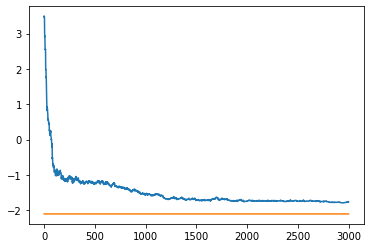

In [42]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

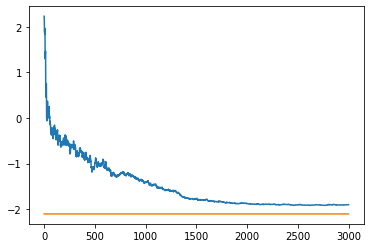

In [47]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [61]:
import pickle

file_to_store = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [114]:
import pickle

file_to_read = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

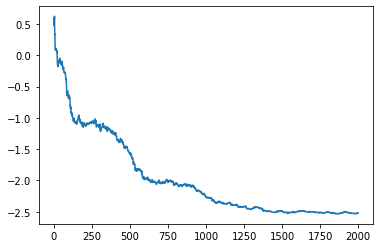

In [115]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [364]:
def SPSA_from_load(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = loaded_object[k]['Delta']
        
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [365]:
El,psi_f = SPSA_from_load(500,method = 'simple',hold = False)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= 0.31221237166560845 E_A= (0.6483890629959139+0j) E_B= (0.39861916566342714+0j) E_f= -0.2941674404659663
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.26600035420340845 E_A= (0.2901614058922417+0j) E_B= (0.48857351440957686+0j) E_f= -0.2754518896460993
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= -0.23292677706300263 E_A= (0.29719469765243134+0j) E_B= (0.4639655536082976+0j) E_f= -0.2587121931480509
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= 0.21234021146877308 E_A= (0.4327031217365752+0j) E_B= (0.28502567555358105+0j) E_f= -0.2459624290385531
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= -0.8282619743549222 E_A= (0.03284742681671075+0j) E_B= (0.5960462515196494+0j) E_f= -0.08100027444187621
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= -0.7447356728411818 E_A= (0.2115041071735653+0j) E_B= (0.7086671847444759+0j) E_f= 0.038152202417291815
k= 6 c_k= 0.32862839767254015 a_k= 0.33949315101716

k= 52 c_k= 0.267860162826851 a_k= 0.2609058398079971 g= -0.6637781002455034 E_A= (-1.0971474553042815+0j) E_B= (-0.7415480352789647+0j) E_f= -1.0994263698402225
k= 53 c_k= 0.26735494522142605 a_k= 0.26008126905440593 g= 1.407911354082114 E_A= (-0.5476712911724904+0j) E_B= (-1.3004954170669851+0j) E_f= -1.2750908604996083
k= 54 c_k= 0.2668599250350944 a_k= 0.2592720285936403 g= 0.3115613639478683 E_A= (-1.0104499459650993+0j) E_B= (-1.176736430419019+0j) E_f= -1.2814667599546898
k= 55 c_k= 0.26637471655715955 a_k= 0.25847760404433856 g= 0.1171148371603351 E_A= (-1.027592537004671+0j) E_B= (-1.0899854001111153+0j) E_f= -1.2818743830349033
k= 56 c_k= 0.2658989552298248 a_k= 0.2576975057492954 g= 0.5293579784046106 E_A= (-0.8792011062133299+0j) E_B= (-1.1607125730140462+0j) E_f= -1.282086350580811
k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= -0.139467602267511 E_A= (-1.0908689506251905+0j) E_B= (-1.0168305388109906+0j) E_f= -1.2801628270984842
k= 58 c_k= 0.26497441264651617 a_

k= 103 c_k= 0.25023014297472496 a_k= 0.23158657254318332 g= 0.16197514333165727 E_A= (-1.5241987206105965+0j) E_B= (-1.6052608471590608+0j) E_f= -1.7613944770531855
k= 104 c_k= 0.24998840873867942 a_k= 0.23118038596666274 g= -0.10559690922187386 E_A= (-1.610454788001996+0j) E_B= (-1.5576587813937979+0j) E_f= -1.76175682998874
k= 105 c_k= 0.24974919607452548 a_k= 0.2307784194017882 g= 0.23095575564585205 E_A= (-1.5114396716308858+0j) E_B= (-1.626801700233558+0j) E_f= -1.7663220086037088
k= 106 c_k= 0.2495124552599996 a_k= 0.23038059318858709 g= 0.35943278297641235 E_A= (-1.4573368947696406+0j) E_B= (-1.636702807132399+0j) E_f= -1.7735644700799984
k= 107 c_k= 0.24927813800651724 a_k= 0.22998682983541768 g= 0.3459481684476991 E_A= (-1.506252183827228+0j) E_B= (-1.6787268143820429+0j) E_f= -1.781116290224153
k= 108 c_k= 0.24904619740500722 a_k= 0.22959705394216187 g= -0.07873932143333032 E_A= (-1.6728575169562512+0j) E_B= (-1.6336380597778082+0j) E_f= -1.7823494830513171
k= 109 c_k= 0.2488

k= 153 c_k= 0.24050294487280224 a_k= 0.21526213181371276 g= 0.008744785336365263 E_A= (-1.7012406417363366+0j) E_B= (-1.7054469349876893+0j) E_f= -1.8713081976727461
k= 154 c_k= 0.24034577371294386 a_k= 0.2149992661706627 g= 0.22835649338188035 E_A= (-1.6435933200044097+0j) E_B= (-1.7533623561728953+0j) E_f= -1.8746302585197436
k= 155 c_k= 0.2401897150315199 a_k= 0.2147383069429348 g= -0.11426817501444562 E_A= (-1.7170791951622109+0j) E_B= (-1.6621871143744278+0j) E_f= -1.8751852786255994
k= 156 c_k= 0.24003475389827156 a_k= 0.21447922894421484 g= -0.28188096762304243 E_A= (-1.780900692284657+0j) E_B= (-1.6455782349006498+0j) E_f= -1.8829435060946635
k= 157 c_k= 0.23988087567680955 a_k= 0.21422200746922634 g= -0.1585448649172057 E_A= (-1.6936271332024946+0j) E_B= (-1.617563371141693+0j) E_f= -1.884116907322624
k= 158 c_k= 0.239728066017013 a_k= 0.21396661828174487 g= -0.16711155153215504 E_A= (-1.7323649605872646+0j) E_B= (-1.6522423024714528+0j) E_f= -1.8846123935717023
k= 159 c_k= 0.

k= 203 c_k= 0.23376922896323718 a_k= 0.20405069669827428 g= 0.13578834536009146 E_A= (-1.6945963510230346+0j) E_B= (-1.7580826246170793+0j) E_f= -1.9496523984210854
k= 204 c_k= 0.23365380153244633 a_k= 0.2038595775662753 g= -0.055417386332366134 E_A= (-1.7638914421314666+0j) E_B= (-1.7379944761563675+0j) E_f= -1.950437165964479
k= 205 c_k= 0.23353899237344763 a_k= 0.20366952306447533 g= -0.11792461007270193 E_A= (-1.795947970823381+0j) E_B= (-1.74086798159856+0j) E_f= -1.9518037972365203
k= 206 c_k= 0.23342479519724088 a_k= 0.20348052237451628 g= -0.09071368922306194 E_A= (-1.6991096595159274+0j) E_B= (-1.6567600108589686+0j) E_f= -1.9520031840421188
k= 207 c_k= 0.23331120380879006 a_k= 0.20329256483718383 g= 0.0483423105819938 E_A= (-1.7528395583647574+0j) E_B= (-1.7753971637183241+0j) E_f= -1.9525761027164394
k= 208 c_k= 0.2331982121051757 a_k= 0.20310563994934921 g= -0.0935832220514162 E_A= (-1.7761447814022004+0j) E_B= (-1.7324979012713366+0j) E_f= -1.9536927717094683
k= 209 c_k= 0

k= 253 c_k= 0.22865030548461726 a_k= 0.19561802104402623 g= 0.0493258290739389 E_A= (-1.7798753465321824+0j) E_B= (-1.8024320783042587+0j) E_f= -1.9759434919769092
k= 254 c_k= 0.22855958199258958 a_k= 0.19546942243156754 g= -0.057220595838998106 E_A= (-1.798263763672948+0j) E_B= (-1.7721071327402913+0j) E_f= -1.9763447043090334
k= 255 c_k= 0.22846924936970905 a_k= 0.19532149575799884 g= 0.05709263782042086 E_A= (-1.7882460155971356+0j) E_B= (-1.814333839811872+0j) E_f= -1.9766798247858155
k= 256 c_k= 0.22837930441497245 a_k= 0.19517423547591145 g= 0.031779577093912076 E_A= (-1.801824982732855+0j) E_B= (-1.8163405781554742+0j) E_f= -1.976889071770436
k= 257 c_k= 0.22828974396591784 a_k= 0.1950276361042541 g= 0.03729601650757049 E_A= (-1.791113483104523+0j) E_B= (-1.8081420792234468+0j) E_f= -1.9768232738242546
k= 258 c_k= 0.22820056489801344 a_k= 0.19488169222729543 g= 0.006766089520059693 E_A= (-1.820123037684761+0j) E_B= (-1.8232110885860173+0j) E_f= -1.9768788105756334
k= 259 c_k= 0.

k= 303 c_k= 0.2245379531555281 a_k= 0.1889158475879403 g= -0.019615701884670322 E_A= (-1.7602038357017515+0j) E_B= (-1.7513948965999657+0j) E_f= -1.98032834121638
k= 304 c_k= 0.22446348815402628 a_k= 0.18879514811017423 g= -0.015041963527366373 E_A= (-1.807511441626499+0j) E_B= (-1.8007586984224224+0j) E_f= -1.9804480317890927
k= 305 c_k= 0.22438929147512626 a_k= 0.1886749079481776 g= -0.005379159727201483 E_A= (-1.7702282511470542+0j) E_B= (-1.7678141994672176+0j) E_f= -1.9804321975331283
k= 306 c_k= 0.2243153612798253 a_k= 0.18855512390879003 g= -0.034871426066510405 E_A= (-1.7960331364346231+0j) E_B= (-1.7803887433617192+0j) E_f= -1.9805199722103088
k= 307 c_k= 0.2242416957476633 a_k= 0.18843579283103418 g= -0.032066339120264485 E_A= (-1.7986848505079438+0j) E_B= (-1.7843036299864483+0j) E_f= -1.980643996427383
k= 308 c_k= 0.22416829307647623 a_k= 0.1883169115856913 g= 0.016437240735645058 E_A= (-1.8042523980589036+0j) E_B= (-1.811621814456097+0j) E_f= -1.9806908605402178
k= 309 c_k

k= 353 c_k= 0.22111115942370668 a_k= 0.18338756003289805 g= 0.03882221520856018 E_A= (-1.7998008757955735+0j) E_B= (-1.8169689258278963+0j) E_f= -1.9820295317492296
k= 354 c_k= 0.2210481719458794 a_k= 0.18328646055073458 g= 0.0071509458131375405 E_A= (-1.8159274534849292+0j) E_B= (-1.8190888604842854+0j) E_f= -1.982010473015273
k= 355 c_k= 0.22098537951573047 a_k= 0.18318569318138667 g= -0.0019019534642685481 E_A= (-1.8242452398534958+0j) E_B= (-1.8234046320372506+0j) E_f= -1.9820130283647297
k= 356 c_k= 0.22092278098392504 a_k= 0.18308525593090869 g= -0.0038706887352812466 E_A= (-1.8230589603195704+0j) E_B= (-1.8213487136801274+0j) E_f= -1.981995495332018
k= 357 c_k= 0.2208603752110963 a_k= 0.1829851468227179 g= -0.02755966959595011 E_A= (-1.7940244271544605+0j) E_B= (-1.7818507492191498+0j) E_f= -1.9818850452459345
k= 358 c_k= 0.22079816106773162 a_k= 0.1828853638973968 g= -0.025775513851473135 E_A= (-1.7944604951253116+0j) E_B= (-1.7830781230073494+0j) E_f= -1.98201530577851
k= 359 

k= 403 c_k= 0.2181802692919501 a_k= 0.178703962236058 g= -0.010292584394149944 E_A= (-1.8269843762250224+0j) E_B= (-1.822493098555371+0j) E_f= -1.9821872263662588
k= 404 c_k= 0.2181257984204375 a_k= 0.17861732579176134 g= -0.01397943804524545 E_A= (-1.8192733892152475+0j) E_B= (-1.813174837045071+0j) E_f= -1.9821662925072885
k= 405 c_k= 0.2180714754281335 a_k= 0.17853093970918948 g= 0.004043741360277849 E_A= (-1.7976272361660897+0j) E_B= (-1.7993908854554608+0j) E_f= -1.9821446936108817
k= 406 c_k= 0.2180172995508166 a_k= 0.17844480266562 g= 0.005504211774597279 E_A= (-1.7852497522691575+0j) E_B= (-1.7876497790436645+0j) E_f= -1.982131343482575
k= 407 c_k= 0.21796327003008015 a_k= 0.17835891334846937 g= 0.0011722443329561072 E_A= (-1.801086633472+0j) E_B= (-1.8015976458881706+0j) E_f= -1.9821261851195617
k= 408 c_k= 0.2179093861132739 a_k= 0.1782732704551914 g= 0.00961478644325766 E_A= (-1.8063669744072754+0j) E_B= (-1.8105572788301965+0j) E_f= -1.982162633667444
k= 409 c_k= 0.21785564

k= 453 c_k= 0.2156241250645643 a_k= 0.17465504553076158 g= 0.009446685368866442 E_A= (-1.8186774143847995+0j) E_B= (-1.8227512809196436+0j) E_f= -1.9826608724809287
k= 454 c_k= 0.21557621389665993 a_k= 0.17457948453338862 g= 0.0191982866251469 E_A= (-1.8247353705263607+0j) E_B= (-1.8330127584142648+0j) E_f= -1.9827637711465338
k= 455 c_k= 0.21552841852324142 a_k= 0.17450411844306418 g= -0.011228681778111526 E_A= (-1.803329787273987+0j) E_B= (-1.7984895872225128+0j) E_f= -1.9827469403049183
k= 456 c_k= 0.21548073841143345 a_k= 0.17442894634039197 g= -0.00574623040761278 E_A= (-1.7894589045678506+0j) E_B= (-1.7869825006252213+0j) E_f= -1.9827223173735788
k= 457 c_k= 0.2154331730319722 a_k= 0.1743539673122692 g= -0.007685584631084743 E_A= (-1.8168967167008234+0j) E_B= (-1.8135852569334627+0j) E_f= -1.9826985403407287
k= 458 c_k= 0.21538572185917312 a_k= 0.1742791804518308 g= 0.0124803870127395 E_A= (-1.802406528289735+0j) E_B= (-1.8077827226213765+0j) E_f= -1.982694716952244
k= 459 c_k= 0

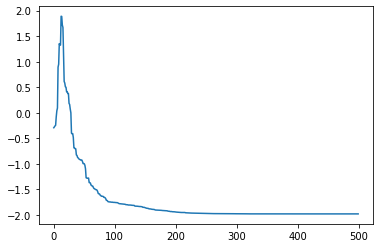

In [367]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [30]:
pwd

'C:\\Users\\jsten\\IBMQ\\Hubbard_symmetries'